# The explainer notebook

## Motivation

We chose to work on the [Game of Thrones Wiki](http://gameofthrones.wikia.com/wiki/Game_of_Thrones_Wiki). We chose this dataset because we all love Game of Thrones, but it contains a lot of characters. We were curious to see if the tools we have learned from this course, were able to detect the important characters, find communities, and find important frases from each community. 

The goal for this was that the end users quickly would be able to see the important characters, know the different communities of Game of Thrones and the important characters within these communities. To give a fast overlook of Game of Thrones and know which characters are important to follow. 

## Basic stats and understanding the dataset

In [3]:
# Importing important stuff
import urllib
import urllib2
import json
import networkx as nx
import io
import re
import matplotlib.pyplot as plt
import wikia
import collections
import operator
import pickle
import os
import nltk
import math
from os import path
import numpy as np
from PIL import Image

### Fetching the data

We had to get every characters wiki page. So first we had to get a list of all characters called *All Characters.txt*. This was created manually using [this](http://gameofthrones.wikia.com/wiki/Category:Characters?display=page&sort=mostvisited) page. Using this textfile we could iterate over it to download every characters Wiki page, as seen below. 
We also wanted to create sentiment analysis on the 60 episodes summary from the Wikipedia page. But these summaries were also manually put into files, since not all episodes were linked to, and not all episodes pages looked similar, so we weren't able to find a way to fetch the data using the API in our amount of time, since we wanted to use the time on some exciting network analysis instead. 

In [ ]:
# Downloading the source wiki page for each character
with open("data/All Characters.txt") as f:
    # For each charatcer
    for l in f:
        # Create the API URL
        url = "http://gameofthrones.wikia.com/api.php?%20action=query&prop=revisions&titles="
        url += urllib.quote(l[:-1].encode('utf-8'))
        url += "&rvprop=content&indexpageids=1&format=json"
        # Load the json file
        wikir=urllib2.urlopen(url)
        wikis=wikir.read()
        wikij=json.loads(wikis, encoding='utf-8')
        
        # Try to get the wiki source
        try:
            k = wikij["query"]["pages"].keys()
            important = wikij["query"]["pages"][k[0]]["revisions"][0]['*']
            # Save the wiki source in a file
            o = open("./data/source/" + l[:-1] +".txt", "wb")
            o.write(important.encode("utf-8"))
            
        # If it fails, create a file for the character 
        except:
            print l[:-1]
            o = open("data/" + l[:-1] +".txt", "wb") #creating a file in their name with the text "no links"
            o.write("no links")

### Creating the network

Now that we have all characters wikipages we are able to create a graph, based on the links in each characters wikipage. So if a character links to another character in the wikipage, it creates a link. The graph is directional, since character *A* might link to character *B*, but not the other way around. 

In [2]:
#Making a list of all characters in the game of thrones universe
allchar = []
with open("data/All Characters.txt") as f:
    for l in f:
        allchar.append(l[:-1])
#Printing the first 10 characters. 
print allchar[:10]

['Aemma Arryn', 'Aemon', 'Aemond Targaryen', 'Aggar', 'Aggo', 'Akho', 'Allo', 'Amaya', 'Anara', 'Andros']


In [3]:
#Creating a directed graph
G=nx.DiGraph()
# Adding the nodes from our list of all characters
G.add_nodes_from(allchar)
for c in allchar: #for every character in allchar, we open the file we saved on the computer
    f=io.open("./data/source/" + c +".txt", 'r', encoding='utf-8')
    links=re.findall(r'(?:\[\[)(.*?)(?:[\|\]])', f.read()) #find all links in that characters got-wikipage
    for l in links: #check all links, and if a link is a character in "allchar" we add a edge between the two
        if l in allchar:
            G.add_edge(c,l)

### Network statistics

Now that we have created our network, we can quickly get some statistics about it. Such as how many nodes and edges the network contains, and what the mean degree is. This is done below:

In [4]:
import numpy as np
print "Number of nodes:"
print len(G.nodes())

print "Number of links"
print len(G.edges())

print "Mean degree"
print np.mean(nx.degree(G).values())

print "Median of degrees"
print np.median(nx.degree(G).values())

Number of nodes:
1012
Number of links
9300
Mean degree
18.3794466403
Median of degrees
9.0


So we can see that there is 9300 links/edges and 1012 nodes (characters). The mean degree of the network is 18.38, and the median degree is 9. We can see that the mean degree is double the amount of the median degree. So most characters don't have a very large degree, but then there are some with a quite high degree. 

We can also plot our network as seen below:

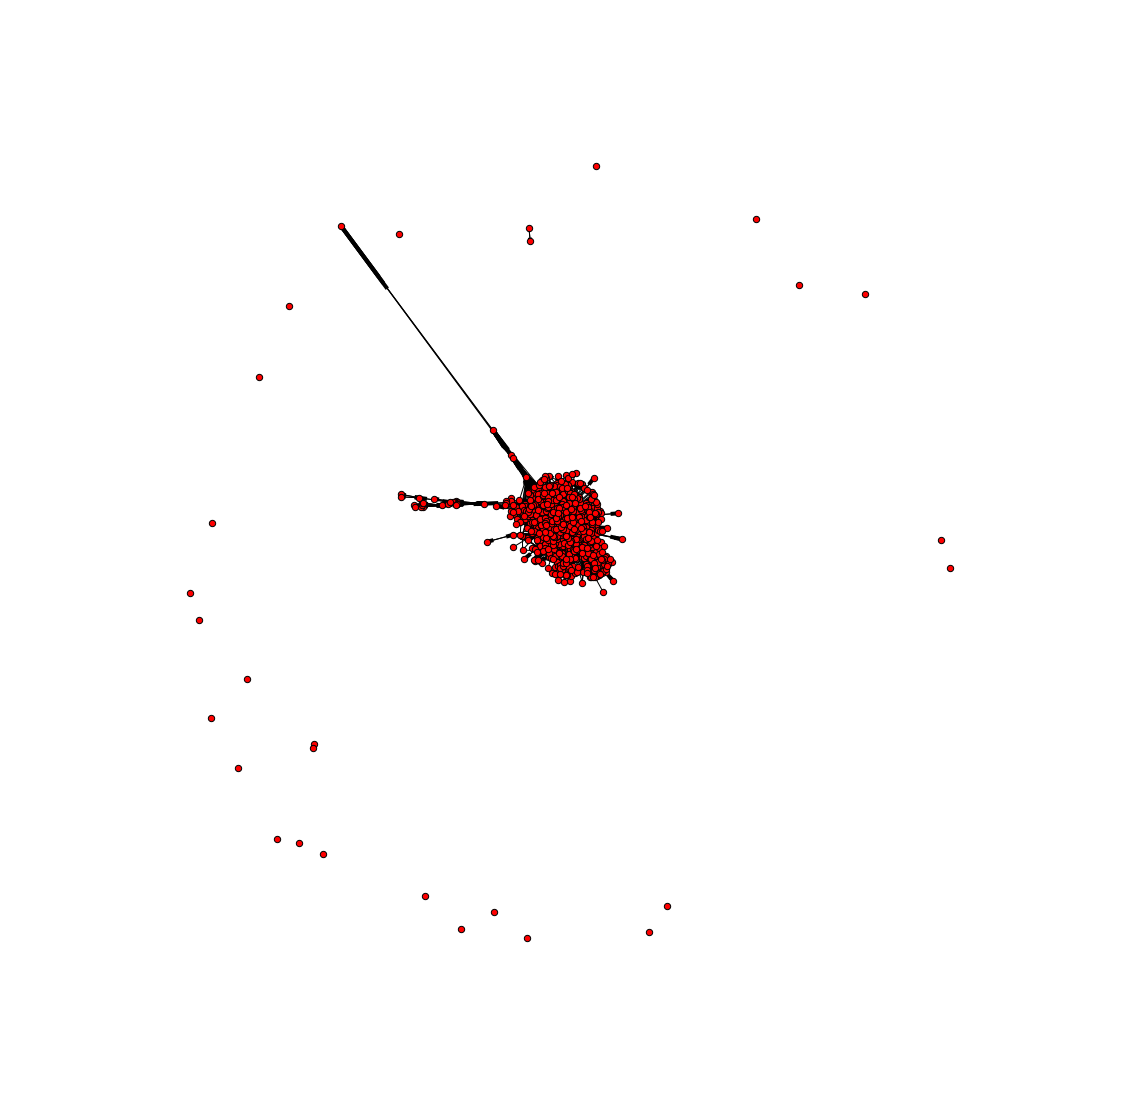

In [5]:
# Plotting our network
plt.figure(figsize=(15,15))
nx.draw(G, node_size=40)
plt.show()

Here we can see that there are some characters that aren't linked at all. So to get rid of them we can work on the biggest weakly connected subgraph:

In [6]:
# Creating a new graph which only has the biggest weakly connected component subgraph. To get rid of all the unlinked nodes
Gweak = max(nx.weakly_connected_component_subgraphs(G), key=len)

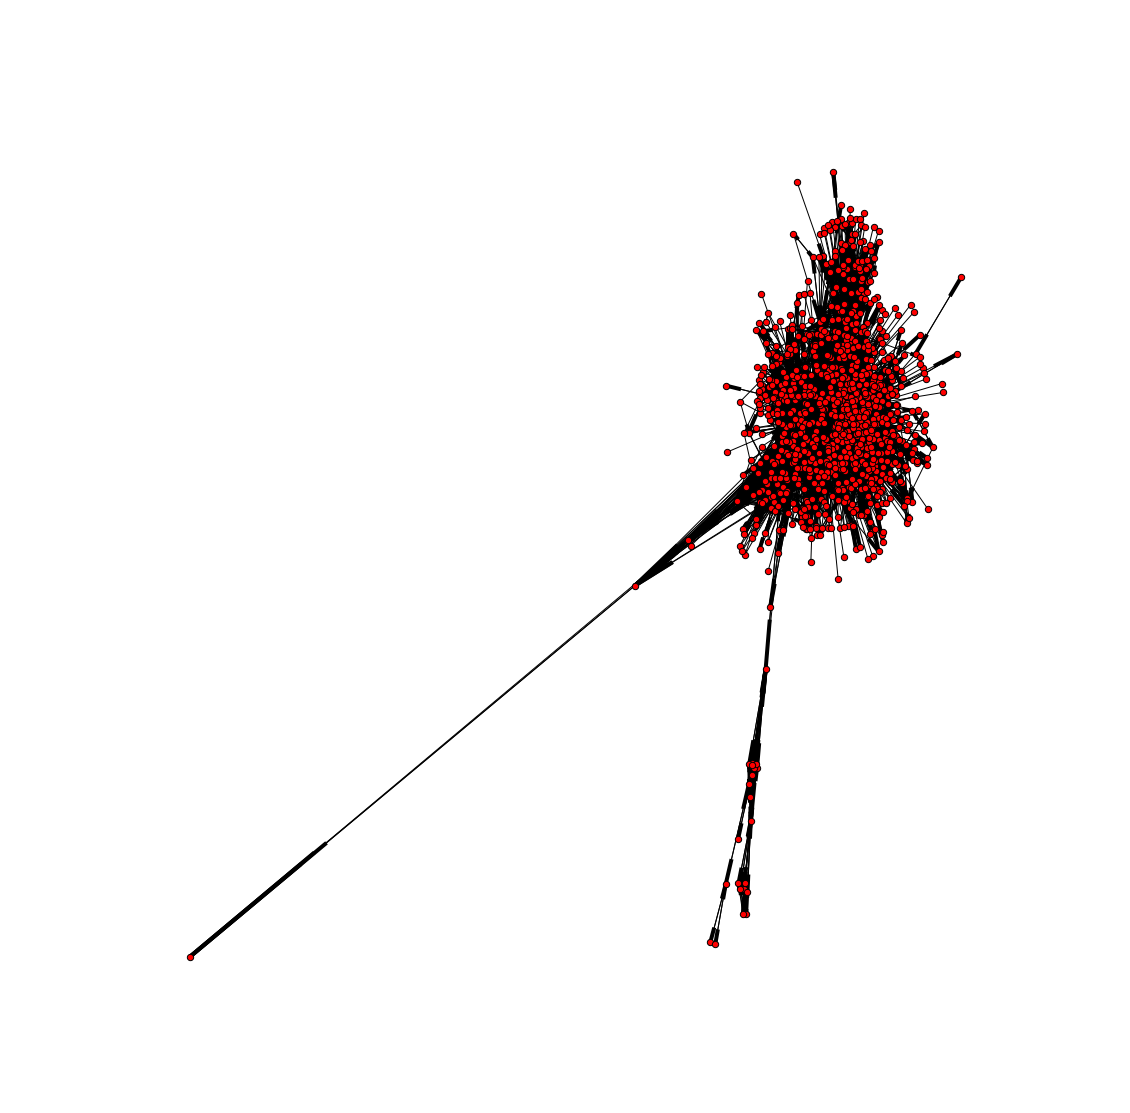

In [7]:
# Plotting the new graph
plt.figure(figsize=(15,15))
nx.draw(Gweak, node_size=40)
plt.show()

Here we can see that most of the nodes are clumped together, but there are some nodes sticking out. These may be the characters from the Game of Thrones mobile game *TellTale*. Since these characters are also included in the Wiki and mainly connect to each other. 

We can also quickly take a look at the degree distribution for the network:

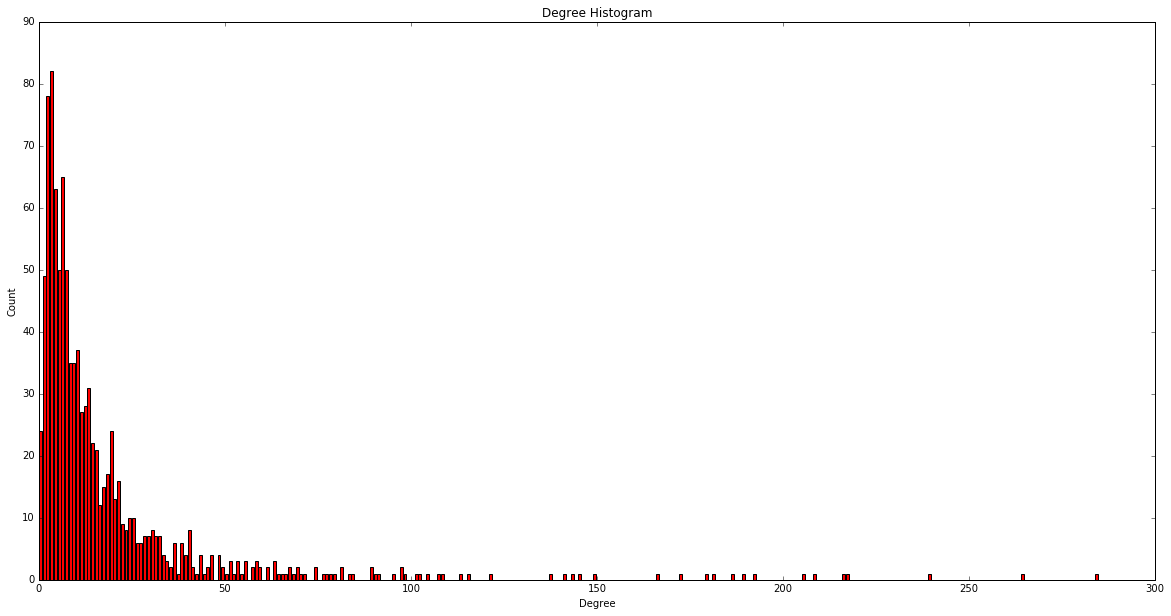

In [8]:
# reverse sorteddegree sequence
degree_sequence=sorted([d for d in G.degree().values()], reverse=True) 
# Counting how many times a specific degree is there
degreeCount=collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

# Plotting a histrogram of the degrees in the network
plt.figure(figsize=(20,10))
plt.bar(deg, cnt, width=0.80, color='r')
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

Here we can clearly see that most characters have an in+out degree of 4. But generally most characters have a degree around 0-20. The higher the degree the fewer characters. The character with the highest degree has a degree of around 280-290. 

## Tools, theory and analysis

### Finding important characters

We want to find the important characters in the Game of Thrones universe. There are several network tools that can be used for this. We want to look at tools such as in/out-degree, betweenness centrality and eigenvector centrality. The tools will be explained in the sections below.

#### In/Out degree

As mentioned above we wanted to find the most important characters in the Game of Thrones universe. Here in and out degree can show us how many links a character have to other characters, and how many characters that link to a specific character. For this we use the **networkx** tool *in_degree* and *out_degree* which calculates this for us. We then want to see the 10 characters with highest in/out degree, since these characters must be important.

All of this is done below

In [9]:
#Getting in degrees of the graph
indl = G.in_degree()
#Sorting the in degrees in reverse order
indls = sorted(indl.items(), key=lambda x: x[1], reverse=True)
#printing the top ten in degree nodes
print "Top 10 indegree"
for i in indls[:10]:
    print i[0], ":",i[1]

print""

#Getting the out degrees of the graph
outdl = G.out_degree()
#Sorting the out degrees in reverse order
outdls = sorted(outdl.items(), key=lambda x: x[1], reverse=True)
#printing the top ten out degree nodes
print "Top 10 outdegree"
for i in outdls[:10]:
    print i[0], ":",i[1]

Top 10 indegree
Tyrion Lannister : 196
Jon Snow : 176
Daenerys Targaryen : 166
Robb Stark : 150
Eddard Stark : 149
Jaime Lannister : 149
Sansa Stark : 134
Stannis Baratheon : 132
Tywin Lannister : 129
Cersei Lannister : 128

Top 10 outdegree
Tyrion Lannister : 88
Jon Snow : 88
Daenerys Targaryen : 73
Arya Stark : 72
Sansa Stark : 71
Jaime Lannister : 68
Robb Stark : 66
Cersei Lannister : 61
Ramsay Bolton : 59
Eddard Stark : 59


Above we can see the characters with highest in and out degree. We can see that the top three in both lists are the same characters in the same order. But the two lists have most of the characters in common. If you know the Game of Thrones universe, these characters in the two lists are very important characters, and we can conclude that the in/out degree actually finds important characters. 

We can also see that the indegree for the characters are a lot higher than the out degree. But this makes sense since if a nonimportant character meets one of these important characters, the important characters are most likely mentioned in the nonimportant characters wiki page, but the nonimportant characters are most likely not mentioned in the important characters wiki page.

#### Eigenvector centrality

Eigenvector centrality is another way to look at how important a node/character is. Eigenvector centrality gives relative scores to each node, but connections to high scoring nodes increases the nodes score more than connections to low scoring nodes [1]. Again we use it to find the top 10 highest scoring nodes on both in and out eigenvector centrality. This is done in the code below using the **networkx** function *nx.eigenvector_centrality(graph)*

In [15]:
# In eigenvector centrality
inEigen=nx.eigenvector_centrality(Gweak)
# Sorting them in correct order
sortedEigenScore = sorted(inEigen.items(), key=operator.itemgetter(1), reverse=True)[:10]
# printing
print "Top 10 in-eigenvector centrality:"
for i in sortedEigenScore:
    print i[0]+":",i[1]
print ""
# out eigenvector centrality
inEigen=nx.eigenvector_centrality(Gweak.reverse())
# Sorting them in correct order and getting top 10
sortedEigenScore = sorted(inEigen.items(), key=operator.itemgetter(1), reverse=True)[:10]
# printing
print "Top 10 out-eigenvector centrality:"
for i in sortedEigenScore:
    print i[0]+":",i[1]

Top 10 in-eigenvector centrality:
Tyrion Lannister: 0.21863037455
Eddard Stark: 0.218333401455
Cersei Lannister: 0.2057101621
Sansa Stark: 0.202116650675
Jaime Lannister: 0.200066648283
Robert Baratheon: 0.194973871517
Tywin Lannister: 0.192988429614
Stannis Baratheon: 0.187530600633
Joffrey Baratheon: 0.186666326895
Robb Stark: 0.185541498434

Top 10 out-eigenvector centrality:
Tyrion Lannister: 0.175727607244
Jon Snow: 0.162832215402
Sansa Stark: 0.161936094722
Jaime Lannister: 0.160262549212
Robb Stark: 0.154804668787
Cersei Lannister: 0.15235076112
Arya Stark: 0.146395312312
Eddard Stark: 0.145583915867
Varys: 0.138494894318
Robert Baratheon: 0.137876119715


Again the two lists contain mainly the same characters, and a lot of the characters from above. So not only do the characters have a high in/out degree but they also connect to other important characters. But an interesting thing here is that Daenerys Targaryen isn't in top 10 here, when she is in top 3 when looking at in/out degree. But if you know the series this also makes sense since even though she is an important character she is still isolated from most of the other important characters. 

#### Betweenness centrality

The last tool we want to use when finding important characters is betweeness centrality. This gives an idea of how central a character/node is to the network. Betweenness centrality looks at how many shortest paths in the network goes through a node [2]. So the node with the highest score is part of the most shortest paths. Here we again use a **networkx** tool: *nx.betweenness_centrality(graph)*. The code can be seen below:

In [16]:
#calculating betweenness centrality
betweencentral= nx.betweenness_centrality(Gweak)
#sorting
sortedbetcen = sorted(betweencentral.items(), key=operator.itemgetter(1), reverse=True)[:10]
# printing
print "Top 10 betweenness centrality:"
for i in sortedbetcen:
    print i[0]+":",i[1]

Top 10 betweenness centrality:
Jon Snow: 0.104388721039
Tyrion Lannister: 0.093385093311
Daenerys Targaryen: 0.0908590487545
Arya Stark: 0.0554179685879
Robb Stark: 0.0391763442811
Morag Umber: 0.0358998424679
Stannis Baratheon: 0.0348370800933
Jaime Lannister: 0.0345934704323
Ramsay Bolton: 0.0322129708364
Cersei Lannister: 0.0280016810367


Again we see a lot of the same characters as we saw when looking at in/out degree and eigenvector centrality. The only one that stands out is Morag Umber. He isn't an important character in the series, but he must have some connections which makes him central to the network when looking at shortests paths. 
But otherwise we can conclude that these tools were useful for finding the important characters in the series. 

### Detecting the network type

We were interested to see if a fictional network such as the Game of Thrones network were more similar to a random network or a real network when looking at hubs and degree. Here we use the already calculated in and out degrees for the network (called *indl* and *outdl* in the code). This is used to create 4 plots of the degree distribution. 2 for in/out degree on a linear scale, and 2 for in/out degree on a log-log scale. This is to see how the degree distribution looks when plotted. The degrees of a random network follow a poisson distribution, since most nodes have a similar amount of links. Where in a real network there are a lot of nodes with few links, and a few nodes with a high number of links, so called hubs. 

We look at the graphs below.

#### In degree on linear scale

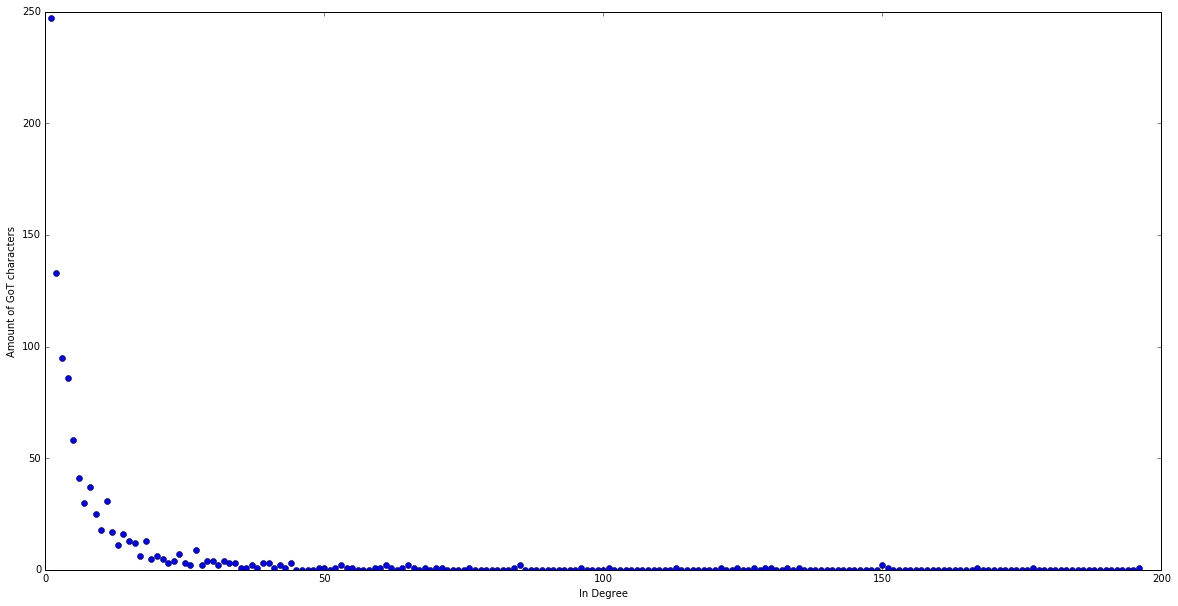

In [17]:
plt.figure(figsize=(20,10))
indeg, bins=np.histogram(indl.values(), bins=max(indl.values()))
x1=[i for i in range(1,max(indl.values())+1)]
plt.plot(x1,indeg,'o')
plt.xlabel('In Degree')
plt.ylabel('Amount of GoT characters')
plt.show()

Here we see that around 250 characters have an indegree of 0, and around 130 have an indegree of 1. So here we clearly see that the degrees follow the power law. Meaning that a lot of characters have a low indegree with fewer hubs.

#### Out degree on linear scale

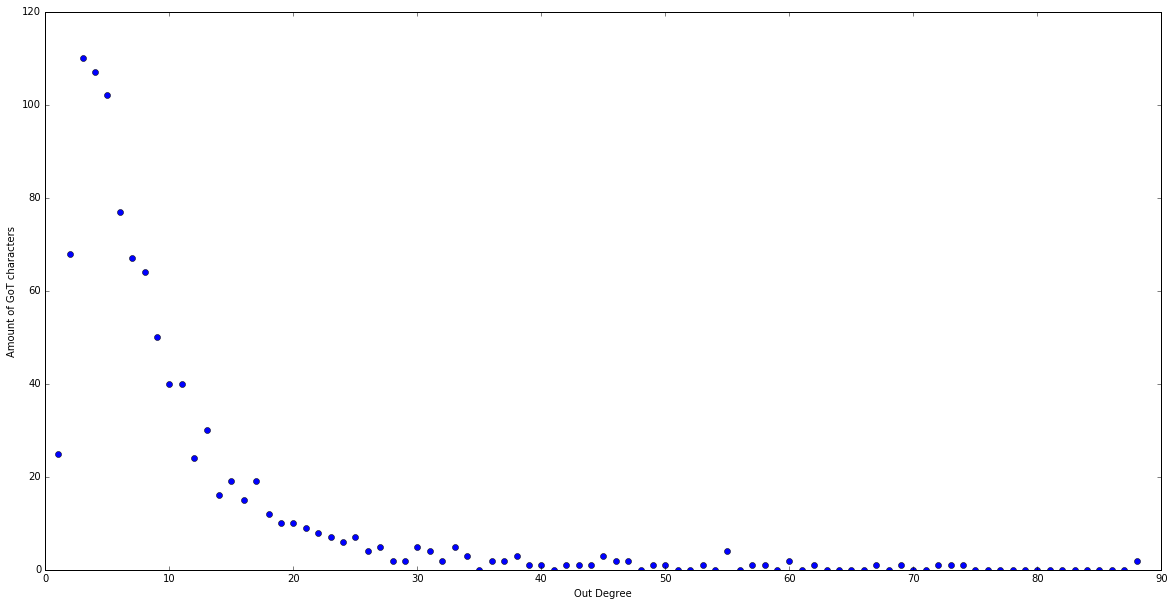

In [18]:
plt.figure(figsize=(20,10))
outdeg, bins=np.histogram(outdl.values(), bins=max(outdl.values()))
x2=[i for i in range(1,max(outdl.values())+1)]
plt.plot(x2,outdeg,'o')
plt.xlabel('Out Degree')
plt.ylabel('Amount of GoT characters')
plt.show()

Here we see that the most normal out degree is actually 2, with around 110 characters having that out degree. Therefore this doesn't look exactly like power-law but it doesn't look like a poisson distribution either. 

#### In degree on log-log scale

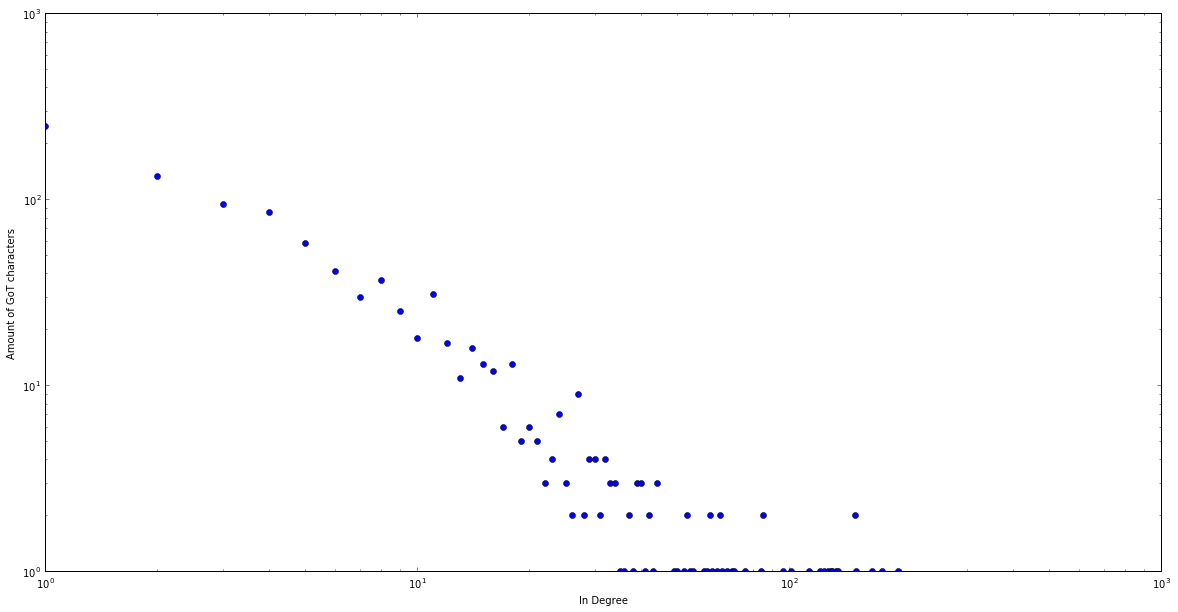

In [19]:
plt.figure(figsize=(20,10))
plt.loglog(x1,indeg,'o', basex=10)
plt.xlabel('In Degree')
plt.ylabel('Amount of GoT characters')
plt.show()

On a log-log scale the power-law should look like a linear line. We can see that the degree distribution follows power-law but with exponentional cutoff, but this is normal for real networks[3].

#### Out degree on log-log scale

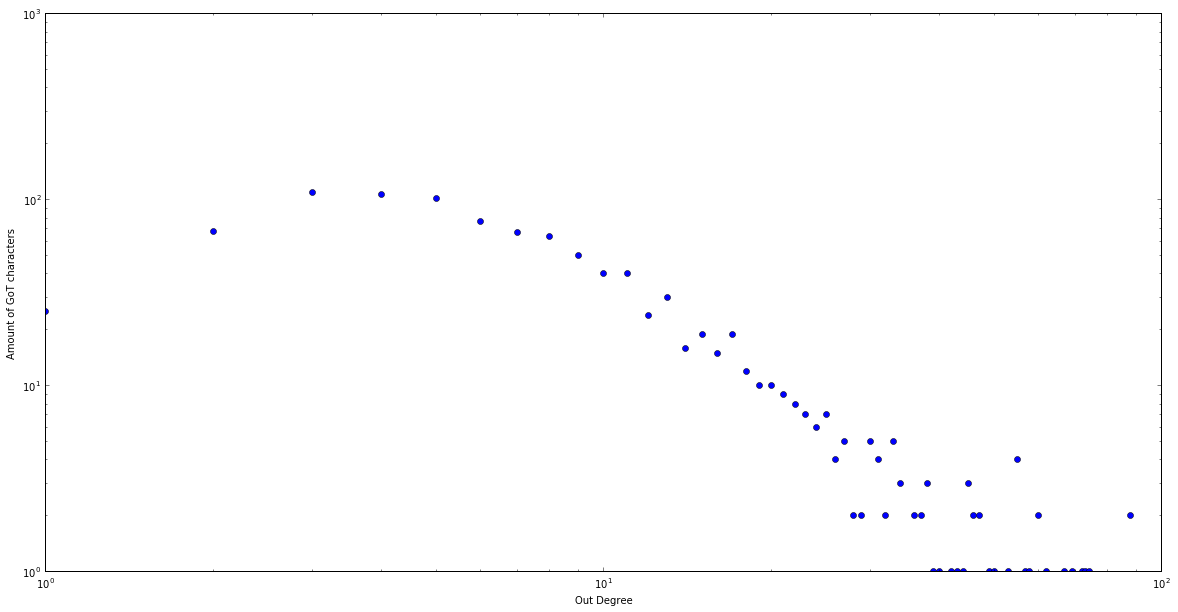

In [20]:
plt.figure(figsize=(20,10))
plt.loglog(x2,outdeg,'o', basex=10)
plt.xlabel('Out Degree')
plt.ylabel('Amount of GoT characters')
plt.show()

Again the out degree looks a bit more special. Since the first part looks more like a poisson distribution, but after that it begins to look like a power-law distribution. 

So we can conclude that the indegree definently is similar to a real network but the out degree is something in between. 

### Comparing in and out degree

We were also interested in finding out if there is a correlation between in and out degree. So if a character has a high out degree do the character then also have high in degree? 

This was tested using the in/out degree we had already calculated and plotting these on a scatter plot, this can be seen below:

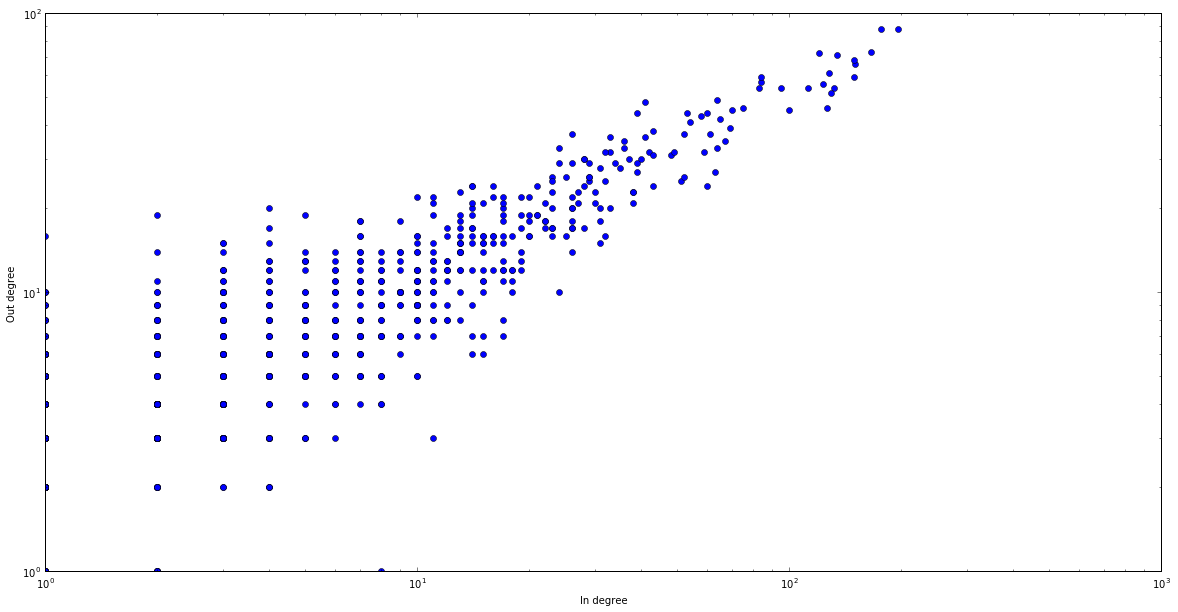

In [21]:
plt.figure(figsize=(20,10))
plt.loglog(indl.values(),outdl.values(),'o', basex=10)
plt.xlabel('In degree')
plt.ylabel('Out degree')
plt.show()

Generally we see that characters degrees matches, so if they have a high indegree they also have a high out degree. When we get to the lower degree characters there are some with a low indegree but relatively high out degree. There aren't as many low degree characters with a small outdegree but a high indegree. This makes sense, since a nonimportant character may link to a lot of other characters in their wiki page. But the characters will probably not link back as mentioned before. 

### Detecting communities

Those who follows Game of Thrones know that the characters are divided into several houses, and would probabaly be able to create some communities for these characters. We are interested in seeing if the network tools we have used in our course *Social graphs and interactions*, can be used to detect this somewhat complicated communities. 

We use the [Python-Louvain](http://perso.crans.org/aynaud/communities/) algorithm to detect the communtiies. This is based on finding the communities which gives the highest modularity. If a network has a high modularity it means that nodes within a community have more connections to each other than to nodes outside the network. Negative modularity is a result of the nodes within the community having more connection to nodes outside the community than inside the community[4]. 

The implentation can be seen below. We start by creating an undirected graph since the algorithm doesn't work on directed graphs, and work on the largest connected component. Hereafter we can find the communities.

In [23]:
import community

In [24]:
#add undirected graph since communities don't work on directed graphs
uG=nx.Graph()
uG.add_nodes_from(G.nodes())
uG.add_edges_from(G.edges())
#Getting the biggest connected component, to avoid small communities of unlinked nodes
uGG = max(nx.connected_component_subgraphs(uG), key = len)

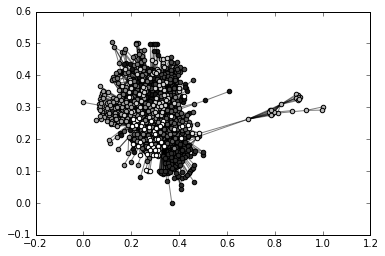

In [28]:
#Getting the best partition of communities on the graph uGG
partition = community.best_partition(uGG)

#drawing the communities graph with colors
size = float(len(set(partition.values())))
pos = nx.spring_layout(uGG)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(uGG, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))

nx.draw_networkx_edges(uGG,pos, alpha=0.5)
plt.show()

In [29]:
print "Number of communities:", max(partition.values())+1
m2 = community.modularity(partition, uGG)
print "Modularity:" ,m2

Number of communities: 11
Modularity: 0.504915288921


So we see that we have 11 communities and the modularity is 0.505. This is a relatively high modularity, meaning that the different communities have more connections to the nodes inside the community than to nodes outside the community. 

Which nodes are inside which communities can be seen below:

In [32]:
#Creating lists of nodes in different communities. So since there was 11 communities we create 11 lists.
com0 = []
com1 = []
com2 = []
com3 = []
com4 = []
com5 = []
com6 = []
com7 = []
com8 = []
com9 = []
com10= []
comall = [com0, com1, com2, com3, com4, com5, com6, com7, com8, com9, com10]
for i in uGG.nodes():
    for k in range(11):
        if partition[i] == k:
            comall[k].append(i)
l = open('communities','w')
pickle.dump(comall,l)
l.close()

for i in range(11):
    print "Community", i
    print comall[i]
    print ""

Community 0
['Joffrey Baratheon', 'Inn waitress', 'Tyene Sand', 'Garlan Tyrell', 'Caleotte', 'Unidentified handmaiden', 'Sorcerer', 'Willas Tyrell', 'Tytos Lannister', u'Alerie Tyrell', 'Lannister bannerman 2 (The Ghost of Harrenhal)', 'Baelish (hedge knight)', "Margaery's handmaiden", 'Robin Arryn', u'Osmund Kettleblack', u'Tyrion Lannister', u'Tommen Baratheon', "Ros's dissatisfied customer", 'Zanrush', 'Hugor of the Hill', 'Falyse Stokeworth', 'Arthur', 'Maggy', 'Dolf', u'Cersei Lannister', "Morgan's friend", u'Dontos Hollard', 'Boake', 'Unella', u'Janos Slynt', 'Armeca', 'Samwell Stone', 'Daemon Sand', 'Protestor', 'Blackmont (Lord)', 'Lyonel Tyrell', 'Merchant captain', 'Orphan kid', 'Lomas Longstrider', 'Helliweg', 'Lannister captain (Home)', 'Whore (The Mother)', 'Lysa Arryn', 'Mors Martell', 'Dwarf 3', 'Dwarf 1', 'Garibald Tarwick', 'Areo Hotah', 'Maynard', 'Nymeria Sand', 'Preston Greenfield', u'Yohn Royce', 'Frances', u'Pycelle', u'Tobho Mott', 'Varly', 'Daeron Targaryen (son

So we can see that the communities are found. We found the communities very impressive, since they actually make sense when comparing to the Game of Thrones universe. 

Com0 are the Lannisters and the people in Kings Landing

Com1 are the characters from the nights watch

Com2 are the Targaryens 

Com3 are the Starks and the people from the north

Com4 are house Forrester from the TellTale game

Com5 are the people from "The tower of joy" which is a flashback.

Com6 are the people from Yunkai

Com7 are the Umbers and Karstarks

Com8 are the people from the House of Black and White. 

Com9 are the people from the pilot episode in the very first scene. 

Com10 are the Baratheons. 

### Important characters inside the communities

Now we want to look at important characters inside the communities. This is done in the same way as it was for the whole network - Looking at in and out degree, eigenvector centrality and betweenness centrality. What these tools does will not be mentioned again since this was mentioned in the section **Finding important characters**.

We start by creating 11 subgraphs where the nodes are the characters inside each community. Here after we create functions for calculating in and out degree, eigenvector centrality and betweenness centrality, to avoid too much redundancy. This is done below:

In [33]:
#Creating subgraphs in the directed graph of all the different communities
subCom0 = G.subgraph(comall[0])
subCom1= G.subgraph(comall[1])
subCom2 = G.subgraph(comall[2])
subCom3 = G.subgraph(comall[3])
subCom4 = G.subgraph(comall[4])
subCom5 = G.subgraph(comall[5])
subCom6 = G.subgraph(comall[6])
subCom7 = G.subgraph(comall[7])
subCom8 = G.subgraph(comall[8])
subCom9 = G.subgraph(comall[9])
subCom10 = G.subgraph(comall[10])
subComsAll = [subCom0, subCom1, subCom2, subCom3, subCom4, subCom5, subCom6, subCom7, subCom8, subCom9, subCom10]

In [34]:
#Creating a function to calculate top 10 in/out degree for a graph
def inOutDeg(graph):
    #Top 10 in degree
    indl = graph.in_degree()
    indls = sorted(indl.items(), key=lambda x: x[1], reverse=True)
    print "Top 10 indegree"
    for i in indls[:10]:
        print i[0], ":",i[1]

    print""
    #Top 10 out degree
    outdl = graph.out_degree()
    outdls = sorted(outdl.items(), key=lambda x: x[1], reverse=True)
    print "Top 10 outdegree"
    for i in outdls[:10]:
        print i[0], ":",i[1]

In [35]:
def eigenCentrality(graph):
    # In eigenvector centrality
    inEigen=nx.eigenvector_centrality(graph)
    # Sorting them in correct order and getting top 10
    sortedEigenScore = sorted(inEigen.items(), key=operator.itemgetter(1), reverse=True)[:10]
    # printing
    print "Top 10 in Eigen Scores"
    for i in sortedEigenScore:
        print i[0]+":",i[1]
    
    print ""
    
    # out eigenvector centrality
    inEigen=nx.eigenvector_centrality(graph.reverse())
    # Sorting them in correct order and getting top 10
    sortedEigenScore = sorted(inEigen.items(), key=operator.itemgetter(1), reverse=True)[:10]
    # printing
    print "Top 10 out Eigen Scores"
    for i in sortedEigenScore:
        print i[0]+":",i[1]

In [36]:
def betweenCentrality(graph):
    #calculating betweenness centrality
    betweencentral= nx.betweenness_centrality(graph)
    #sorting
    sortedbetcen = sorted(betweencentral.items(), key=operator.itemgetter(1), reverse=True)[:10]
    # printing
    print "Top 10 betweenness centrality"
    for i in sortedbetcen:
        print i[0]+":",i[1]

Now that we have the three functions we can use them to find the top 10 nodes/characters with the highest score for each community when looking at the in and out degree, the eigenvector centrality and the betweennesss centrality.

In [37]:
#Printing top 10 in/out degree for all the different communities.
for i in range(11):
    print "Community:", i 
    inOutDeg(subComsAll[i])
    print ""
    eigenCentrality(subComsAll[i])
    print ""
    betweenCentrality(subComsAll[i])
    print "________________________________"

Community: 0
Top 10 indegree
Tyrion Lannister : 107
Cersei Lannister : 86
Joffrey Baratheon : 72
Tywin Lannister : 68
Petyr Baelish : 58
Tommen Baratheon : 45
Robert Baratheon : 44
Oberyn Martell : 44
Margaery Tyrell : 44
Bronn : 43

Top 10 outdegree
Cersei Lannister : 39
Tyrion Lannister : 38
Bronn : 37
Petyr Baelish : 31
Oberyn Martell : 29
Joffrey Baratheon : 27
Tywin Lannister : 27
Ellaria Sand : 27
Varys : 26
Pycelle : 26

Top 10 in Eigen Scores
Cersei Lannister: 0.306071878516
Tyrion Lannister: 0.29168500241
Tywin Lannister: 0.262685424378
Joffrey Baratheon: 0.252247501589
Loras Tyrell: 0.217892849368
Robert Baratheon: 0.210870318298
Petyr Baelish: 0.210676185086
Varys: 0.202801188109
Pycelle: 0.200749055304
Tommen Baratheon: 0.197348961046

Top 10 out Eigen Scores
Cersei Lannister: 0.233807911744
Tyrion Lannister: 0.218861540427
Bronn: 0.196907860133
Pycelle: 0.180446842296
Oberyn Martell: 0.180294507601
Varys: 0.17983180817
Joffrey Baratheon: 0.178455374285
Tywin Lannister: 0.1

When looking seperately at each community we can see that mainly the same characters are shown in the top 10 for in/out degree, eigenvector centrality and betweenness centrality. But we also see that it indeed is the important characters from each community that are in the top 10. So we actually get a good overview of the important characters inside the different communities in the Game of Thrones universe.

### Wordclouds for each community

To create wordclouds for each community, we have decided to look at the tf-idf values for the 11 communities. Thus describing each community with the words used the most. We have decided to keep the names of characters as words of significance, as they help us describing the community.

In [4]:
#Loading the communities from our binary file
comall = pickle.load(open('communities','r'))

In [5]:
#save path to the folder of data
save_path = 'data\source'

So first we calculate the tf-idf values through the following code blocks.

In [6]:
#Used to tokenize each wiki page
def page_tokenization(page_list):
    token_list = []
    count=0
    for p in page_list:
        completename = os.path.join(save_path, p + '.txt') #Path to open
        try:
            f = io.open(completename.encode('utf-8'),'r',encoding='utf-8')
        except:
            continue
        #Tokenization
        tokens = nltk.word_tokenize(f.read()) #Tokenize the page
        tokens = [x.lower() for x in tokens if x.isalpha()]
        token_list = token_list + list(tokens)
        f.close()
        
    return token_list

In [7]:
#Tokenizing all the pages in each of the 11 communities.
t0 = page_tokenization(comall[0])
t1 = page_tokenization(comall[1])
t2 = page_tokenization(comall[2])
t3 = page_tokenization(comall[3])
t4 = page_tokenization(comall[4])
t5 = page_tokenization(comall[5])
t6 = page_tokenization(comall[6])
t7 = page_tokenization(comall[7])
t8 = page_tokenization(comall[8])
t9 = page_tokenization(comall[9])
t10 = page_tokenization(comall[10])

In [8]:
#Calculating the frequency of the different words in the 11 communities.
f0  = nltk.FreqDist(t0)
f1  = nltk.FreqDist(t1)
f2  = nltk.FreqDist(t2)
f3  = nltk.FreqDist(t3)
f4  = nltk.FreqDist(t4)
f5  = nltk.FreqDist(t5)
f6  = nltk.FreqDist(t6)
f7  = nltk.FreqDist(t7)
f8  = nltk.FreqDist(t8)
f9  = nltk.FreqDist(t9)
f10  = nltk.FreqDist(t10)

In [9]:
#Used to threshold away some of the not so significant words.
def thresh(f):
    thr = [key for key in f if f[key] > 5] #Threshold for word count is chosen to be 5
    f_thr = {i: (1+np.log(f[i])) for i in thr} #Put in the TF
    return f_thr

In [10]:
#Using the threshold function on all 11 community frequencies
f0_thr = thresh(f0)
f1_thr = thresh(f1)
f2_thr = thresh(f2)
f3_thr = thresh(f3)
f4_thr = thresh(f4)
f5_thr = thresh(f5)
f6_thr = thresh(f6)
f7_thr = thresh(f7)
f8_thr = thresh(f8)
f9_thr = thresh(f9)
f10_thr = thresh(f10)

In [11]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english') #For removing stopwords

In [12]:
#Removing stopwords from the frequency lists.
f0 = {i: f0_thr[i] for i in f0_thr if i not in stopwords}
f1 = {i: f1_thr[i] for i in f1_thr if i not in stopwords}
f2 = {i: f2_thr[i] for i in f2_thr if i not in stopwords}
f3 = {i: f3_thr[i] for i in f3_thr if i not in stopwords}
f4 = {i: f4_thr[i] for i in f4_thr if i not in stopwords}
f5 = {i: f5_thr[i] for i in f5_thr if i not in stopwords}
f6 = {i: f6_thr[i] for i in f6_thr if i not in stopwords}
f7 = {i: f7_thr[i] for i in f7_thr if i not in stopwords}
f8 = {i: f8_thr[i] for i in f8_thr if i not in stopwords}
f9 = {i: f9_thr[i] for i in f9_thr if i not in stopwords}
f10 = {i: f10_thr[i] for i in f10_thr if i not in stopwords}

In [13]:
#Sorting the frequency lists.
f0 = sorted(f0.items(), key=lambda x: x[1],reverse=True)
f1 = sorted(f1.items(), key=lambda x: x[1],reverse=True)
f2 = sorted(f2.items(), key=lambda x: x[1],reverse=True)
f3 = sorted(f3.items(), key=lambda x: x[1],reverse=True)
f4 = sorted(f4.items(), key=lambda x: x[1],reverse=True)
f5 = sorted(f5.items(), key=lambda x: x[1],reverse=True)
f6 = sorted(f6.items(), key=lambda x: x[1],reverse=True)
f7 = sorted(f7.items(), key=lambda x: x[1],reverse=True)
f8 = sorted(f8.items(), key=lambda x: x[1],reverse=True)
f9 = sorted(f9.items(), key=lambda x: x[1],reverse=True)
f10 = sorted(f10.items(), key=lambda x: x[1],reverse=True)

In [14]:
#Making sets of token dictionaries.
token_dict = {0: set(t0),1: set(t1),2: set(t2),3: set(t3),4: set(t4),5: set(t5),6: set(t6),7: set(t7),8: set(t8),9: set(t9),10: set(t10)}

In [15]:
#Calculation function for each page's idf
def calcidf(token_dict,N,word):
    count = 0
    for i in range(1,N+1):
        if word in token_dict[i]:
            count += 1
    idf = np.log(N/(float(count)+1))
    return idf

In [16]:
#Using the idf calculation function on each community's thresholded frequency list
idf0 = {f: calcidf(token_dict,6,f) for f in f0_thr}
idf1 = {f: calcidf(token_dict,6,f) for f in f1_thr}
idf2 = {f: calcidf(token_dict,6,f) for f in f2_thr}
idf3 = {f: calcidf(token_dict,6,f) for f in f3_thr}
idf4 = {f: calcidf(token_dict,6,f) for f in f4_thr}
idf5 = {f: calcidf(token_dict,6,f) for f in f5_thr}
idf6 = {f: calcidf(token_dict,6,f) for f in f6_thr}
idf7 = {f: calcidf(token_dict,6,f) for f in f7_thr}
idf8 = {f: calcidf(token_dict,6,f) for f in f8_thr}
idf9 = {f: calcidf(token_dict,6,f) for f in f9_thr}
idf10 = {f: calcidf(token_dict,6,f) for f in f10_thr}

In [17]:
#method for finding TF-IDF values
def tfidf(f,idf):
    tf_idf = {k: f[k]*idf[k] for k in f}
    return tf_idf

In [18]:
#Calculating each tf-idf vector for each community
tf_idf0 = tfidf(f0_thr,idf0)
tf_idf1 = tfidf(f1_thr,idf1)
tf_idf2 = tfidf(f2_thr,idf2)
tf_idf3 = tfidf(f3_thr,idf3)
tf_idf4 = tfidf(f4_thr,idf4)
tf_idf5 = tfidf(f5_thr,idf5)
tf_idf6 = tfidf(f6_thr,idf6)
tf_idf7 = tfidf(f7_thr,idf7)
tf_idf8 = tfidf(f8_thr,idf8)
tf_idf9 = tfidf(f9_thr,idf9)
tf_idf10 = tfidf(f10_thr,idf10)

Now that we have the tf-idf vectors for each of the 11 communities, we create wordclouds for each community. To do this we create a string for each community consisting of the individual words repeated (depending on how high of a tf-idf value it has) thus allowing us to use the wordcloud creater used in the course.

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy.misc import imread

In [20]:
#This function translates the tf-idf vector into a string with repeated words based on the words tf-idf value.
def wordtextmaker(tf_idf):
    wordtext =''
    for k in tf_idf:
        wordtext = wordtext + (k +' ')*int(np.ceil(tf_idf[k]))
    return wordtext

In [21]:
#Using the wordtextmaker function to make a string for each of the 11 communities
wordtext0 = wordtextmaker(tf_idf0)
wordtext1 = wordtextmaker(tf_idf1)
wordtext2 = wordtextmaker(tf_idf2)
wordtext3 = wordtextmaker(tf_idf3)
wordtext4 = wordtextmaker(tf_idf4)
wordtext5 = wordtextmaker(tf_idf5)
wordtext6 = wordtextmaker(tf_idf6)
wordtext7 = wordtextmaker(tf_idf7)
wordtext8 = wordtextmaker(tf_idf8)
wordtext9 = wordtextmaker(tf_idf9)
wordtext10 = wordtextmaker(tf_idf10)

For each wordcloud, we have chosen an image mask holding significance to the community. For example, community 1 has a lot to do with the Lannisters, thus the image used is their house sigil.

In [22]:
#Loading each of the masks used for the individual wordclouds
lannister_mask = np.array(Image.open(path.join(".\data\pics\pics", "LannisterBLACK.png")))
nightswatch_mask = np.array(Image.open(path.join(".\data\pics\pics", "NightswatchBLACK.png")))
targaryen_mask =np.array(Image.open(path.join(".\data\pics\pics", "TargarynBLACK.png")))
stark_mask = np.array(Image.open(path.join(".\data\pics\pics", "StarkBLACK.png")))
forrester_mask = np.array(Image.open(path.join(".\data\pics\pics", "ForresterBLACK.png")))
towerjoy_mask = np.array(Image.open(path.join(".\data\pics\pics", "TowerBLACK.png")))
towerjoy2_mask = np.array(Image.open(path.join(".\data\pics\pics", "DayneBLACK.png")))
yunkai_mask = np.array(Image.open(path.join(".\data\pics\pics", "YunkaiBLACK.png")))
umber_mask = np.array(Image.open(path.join(".\data\pics\pics", "UmberBLACK.png")))
blackwhite_mask = np.array(Image.open(path.join(".\data\pics\pics", "aryaBLACK.png")))
iron_mask = np.array(Image.open(path.join(".\data\pics\pics", "whiteBLACK.png")))
baratheon_mask = np.array(Image.open(path.join(".\data\pics\pics", "BaratheonBLACK.png")))

In [23]:
#Function made to generate wordcloud with corresponding mask and then plot it
def wordcloudplotter(wordtext,number,maskname):
    wordcloud = WordCloud(background_color="white", mask=maskname, max_words = 2000).generate(wordtext)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Word cloud for Community' + ' ' + str(number))
    plt.show()

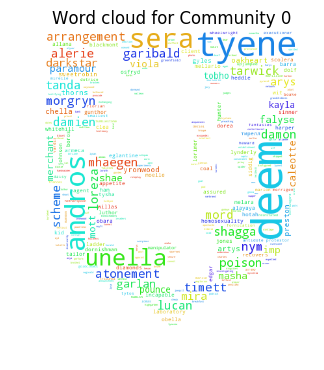

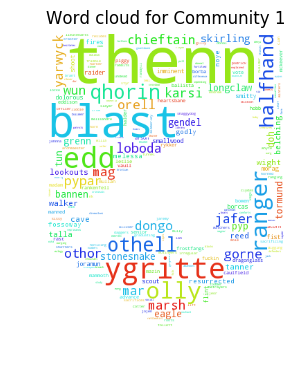

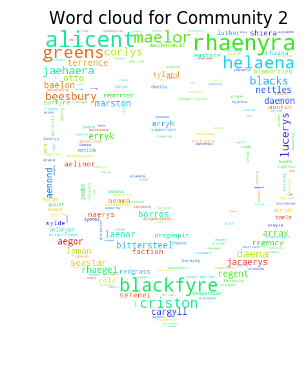

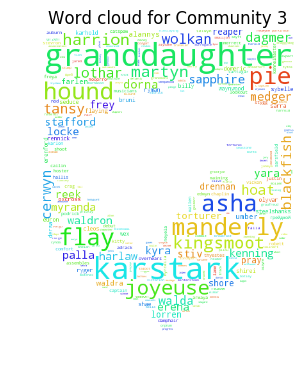

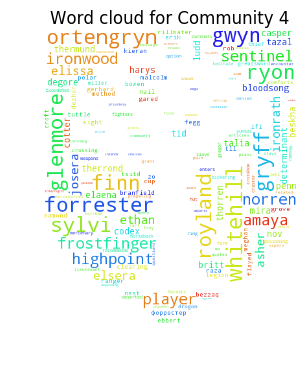

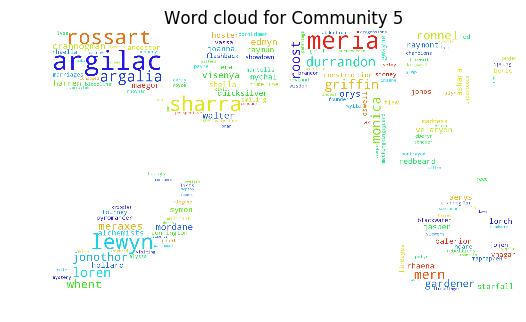

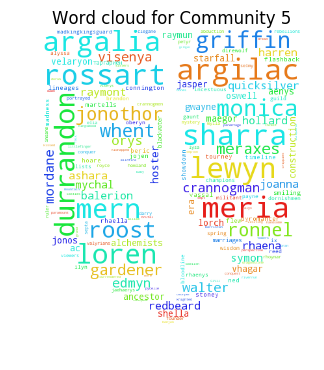

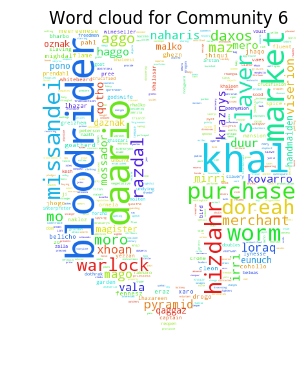

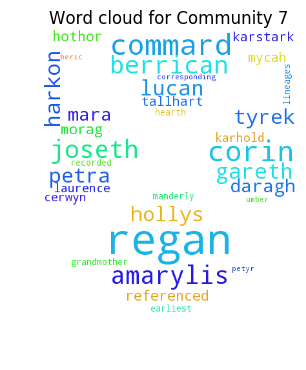

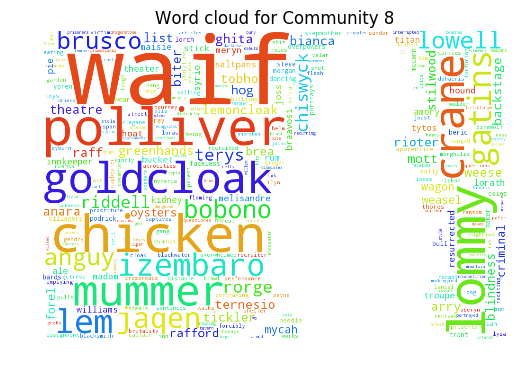

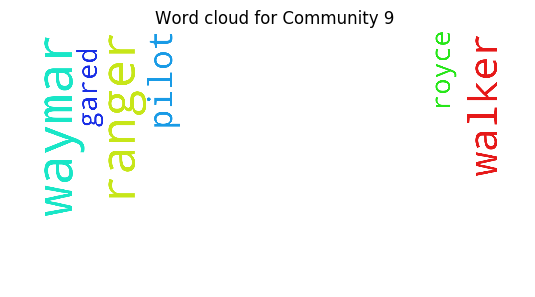

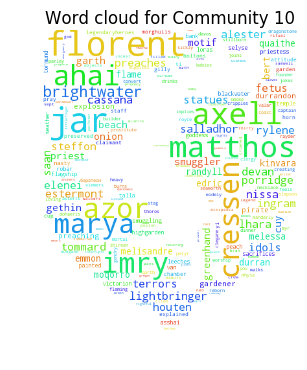

In [24]:
#Plotting all 11 wordclouds
wordcloudplotter(wordtext0,0,lannister_mask)
wordcloudplotter(wordtext1,1,nightswatch_mask)
wordcloudplotter(wordtext2,2,targaryen_mask)
wordcloudplotter(wordtext3,3,stark_mask)
wordcloudplotter(wordtext4,4,forrester_mask)
wordcloudplotter(wordtext5,5,towerjoy_mask) #We have two different 
wordcloudplotter(wordtext5,5,towerjoy2_mask) #image masks for the Tower of Joy flashback community
wordcloudplotter(wordtext6,6,yunkai_mask)
wordcloudplotter(wordtext7,7,umber_mask)
wordcloudplotter(wordtext8,8,blackwhite_mask)
wordcloudplotter(wordtext9,9,iron_mask)
wordcloudplotter(wordtext10,10,baratheon_mask)

Looking at the wordclouds for each community, gives us an idea of what has significance for each of them.

**Community 0**, the Lannister community, deals for example with things such as "Unella", the septa who terrorizes Cersei during her walk of "atonement".

**Community 1**, the Nightswatch community, deals with the tribe "Thenn" while apparently the characters Ygritte and Olly is mentioned a lot. Quite funny that they are so significant when Olly isn't even a character in the books, while Jon Snow is nowhere to be seen. 

**Community 2**, the Targaryen community, this community mainly just shows the names of people in the targaryen family, but it does also show that the "Blackfyre" house has significance for the Targaryen's, which makes sense as this is the house founded by a bastard Targaryen.

**Community 3**, The Starks and the people from the north community, here we see a lot of the names of the "smaller" houses of the north, while also mentioning key characters like Asha Greyjoy and the Blackfish. It's quite funny to see that the Karstarks is mentioned so much, but it makes sense storywise as they are one of the houses who sides with Bolton.

**Community 4**, The house Forrester from the Telltale games community, we sadly haven't played any of the games. But it appears to mainly have names of people/places, it's quite funny though that the word "Player" has significance, as it shows that the player has some kind of influence in the game.

**Community 5**, The Tower of Joy flashback community, this basically consists of a lot of names and places used in the various flashbacks (mostly the Tower of Joy flashback though)

**Community 6**, The Yunkai community, this community consists of the people Daenerys hangs out with, thus we have significant words like "Khal", "Missandei" and "Warlock". In this community we also see that some people can show up twice through both their first name and last name "Daario Naharis"

**Community 7**, The Umbers and Karstark community, just a lot of names of places and people again.

**Community 8**, The People from the house of Black and White, this wordcloud is basically the story of Arya Stark. Seeing as the Waif, Jaqen has great significance during her training to become a faceless (wo)man. The word chicken is said by the Hound a lot who Arya does a lot with in the first few seasons. A lot of the names on the wordcloud are also either people Arya is assigned to kill, or she assigns Jaqen to kill.

**Community 9**, The pilot episode community, this is the pilot episode with the nightswatch rangers who encounters a whitewalker and gets killed.

**Community 10**, the house Baratheon community, in this community we see that "Azor" and "Ahai" has significance, which makes sense as Mellisandre thinks Stannis is "Azor Ahai", furthermore we see the word "Brightwater" which is the place the battle between Stannis Baratheon and Joffrey Baratheon takes place at the ending of season 2. Also words like "Priest" and "Pirate" shows up in the sense that we have Mellisandre the red priest, and Davos the pirate (both the of great significance for Stannis Baratheon, which this wordcloud seems to be mainly about).

After the wordclouds was made, we put them back onto the mask image in photoshop for use on our website. Thus creating neat looking wordclouds!

### Sentiment analysis for every episode

We chose to use sentiment analysis on each episode of each season to create an overview of the "mood" in each episode. To do this, we created txt files for each episode with their corresponding summary from the wiki. Sadly the different pages had different setups, and the pagenames didn't lign up with the actual episode names, thus we copied each summary by hand to a txt file. Not the most optimal way, but it got the work done and allowed us to do the fun part instead. To do the sentiment analysis, we use the LabMT wordlist used in semester week 7.

In [52]:
import pandas as pd
words = pd.read_table('Data_Set_S1.txt',sep='\t',engine='python')
words = words.set_index('word')

In [53]:
#This is the function used to calculate the sentiment for the different token words
def sentiment(tokens,words):
    nodata = []
    res = 0
    for t in tokens:
        if t.lower() in words.index:
            res += words.happiness_average[t.lower()]
        else:
            nodata.append(t)
            
    if len(nodata) == len(tokens):
        print "Error! No words with sentiment attached!"
        
    return res

In [54]:
#we create lists for each season consisting of the episode names
season1names = []
save_path1 = '.\data\episodes\Season1'
for file in os.listdir(save_path1):
    season1names.append(file)
    
season2names = []
save_path2 = '.\data\episodes\Season2'
for file in os.listdir(save_path2):
    season2names.append(file)
    
season3names = []
save_path3 = '.\data\episodes\Season3'
for file in os.listdir(save_path3):
    season3names.append(file)
    
season4names = []
save_path4 = '.\data\episodes\Season4'
for file in os.listdir(save_path4):
    season4names.append(file)
    
season5names = []
save_path5 = '.\data\episodes\Season5'
for file in os.listdir(save_path5):
    season5names.append(file)
    
season6names = []
save_path6 = '.\data\episodes\Season6'
for file in os.listdir(save_path6):
    season6names.append(file)

In [55]:
#Function made to read the episode's txt file into a string
def episode_reader(page_list,save_path):
    season =[]
    for p in page_list:
        completename = os.path.join(save_path, p) #Path to open
        try:
            f = io.open(completename.encode('utf-8'),'r',encoding='utf-8')
        except:
            continue
        season.append(f.read())
        f.close()
    return season

In [56]:
#Calling the episode reader function for each of the 6 seasons.
season1=episode_reader(season1names,save_path1)
season2=episode_reader(season2names,save_path2)
season3=episode_reader(season3names,save_path3)
season4=episode_reader(season4names,save_path4)
season5=episode_reader(season5names,save_path5)
season6=episode_reader(season6names,save_path6)

In [57]:
#Function made to calculate the moving average.
def movingavg(text,window,words):
    res = []
    for i in range(len(text)/window):
             res.append(sentiment(text[i*window:(i+1)*window],words)/window)
    return res

In [58]:
#First we remove all the tokens that aren't made from letters in the alphabet.
t1={}
t2={}
t3={}
t4={}
t5={}
t6={}
for i in range(10):
    t1[i] = [w for w in season1[i] if w.isalpha()]
    t2[i] = [w for w in season2[i] if w.isalpha()]
    t3[i] = [w for w in season3[i] if w.isalpha()]
    t4[i] = [w for w in season4[i] if w.isalpha()]
    t5[i] = [w for w in season5[i] if w.isalpha()]
    t6[i] = [w for w in season6[i] if w.isalpha()]

In [59]:
#Then we calculate the moving average for all 6 seasons with a window of 15
a1= {}
a2= {}
a3= {}
a4= {}
a5= {}
a6= {}
for i in range(10):
    a1[i] = movingavg(t1[i],15,words)
    a2[i] = movingavg(t2[i],15,words)
    a3[i] = movingavg(t3[i],15,words)
    a4[i] = movingavg(t4[i],15,words)
    a5[i] = movingavg(t5[i],15,words)
    a6[i] = movingavg(t6[i],15,words)

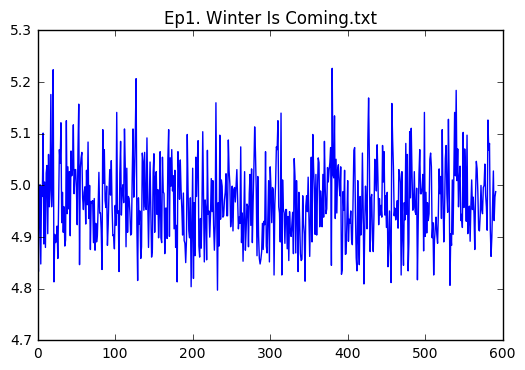

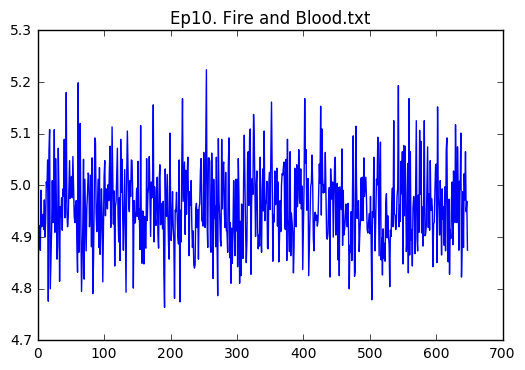

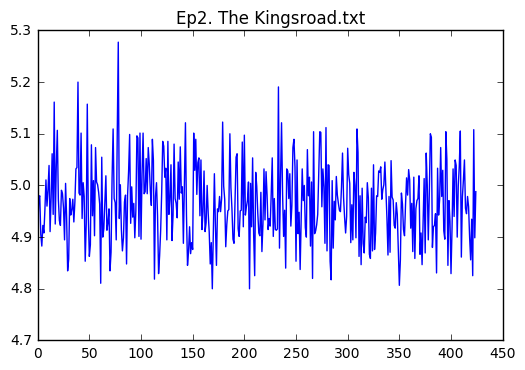

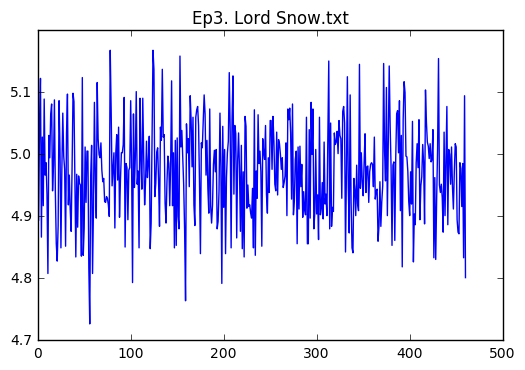

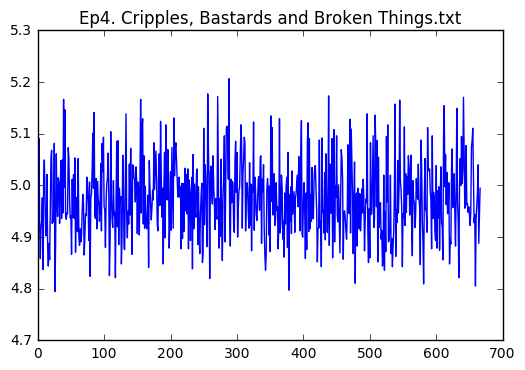

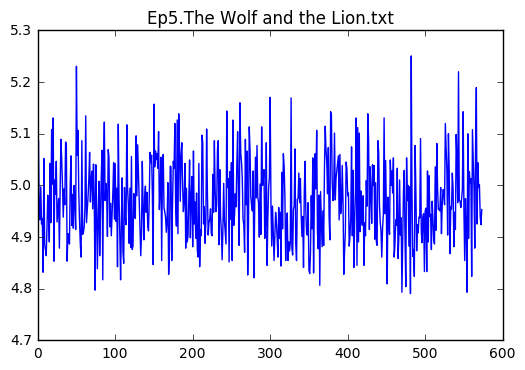

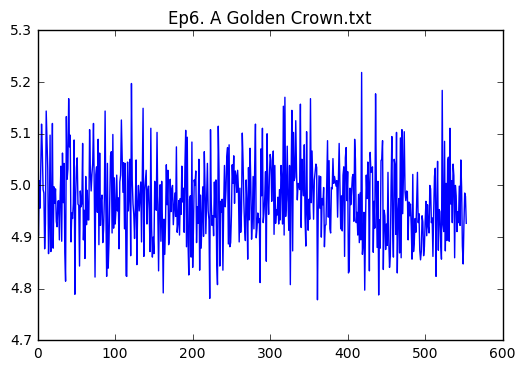

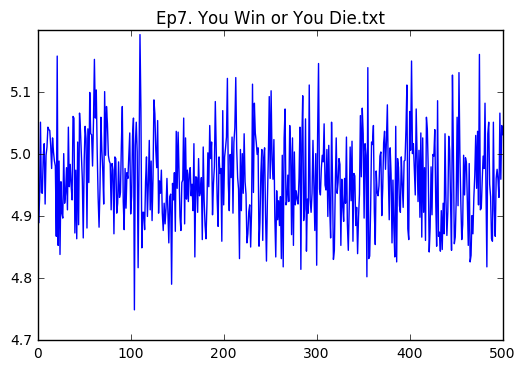

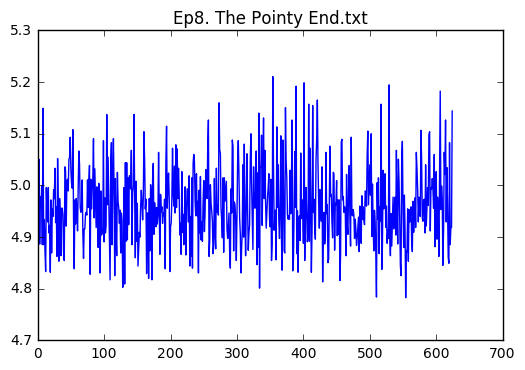

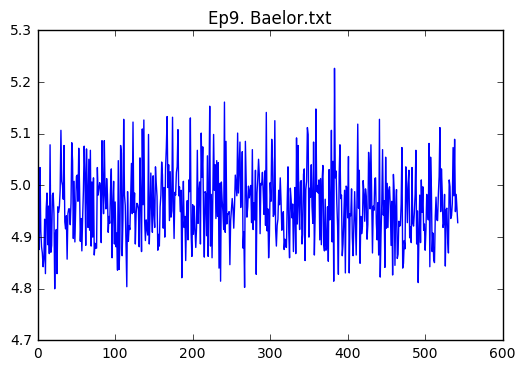

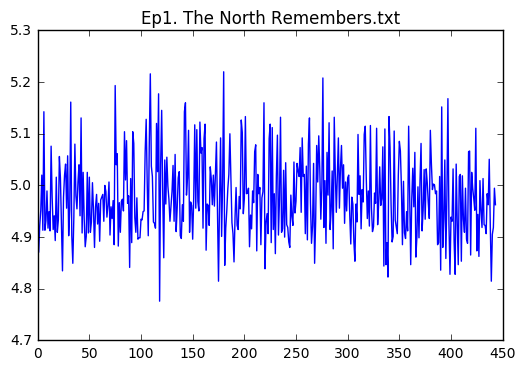

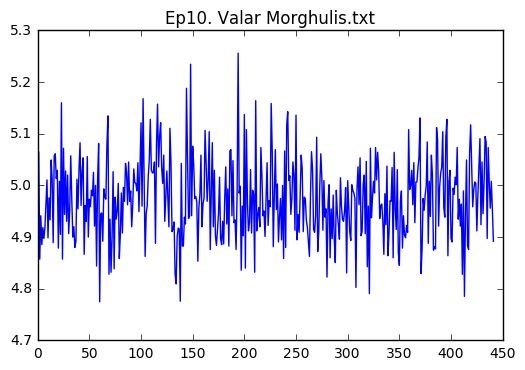

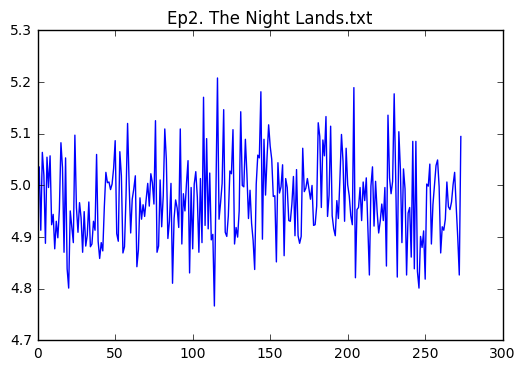

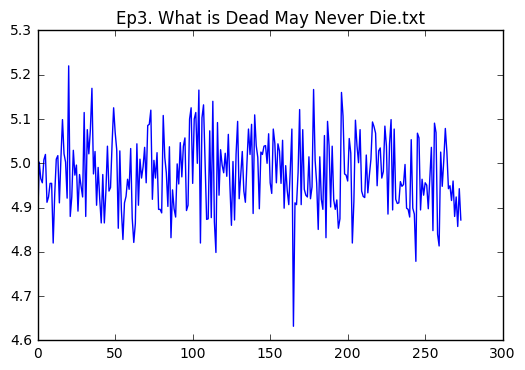

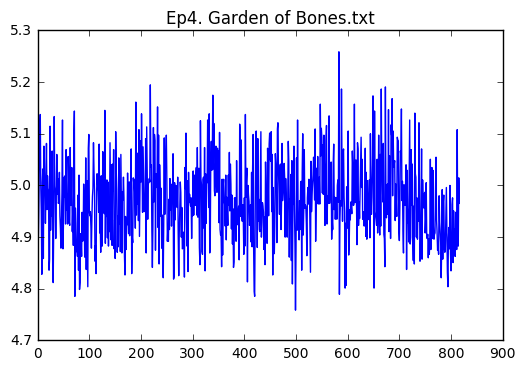

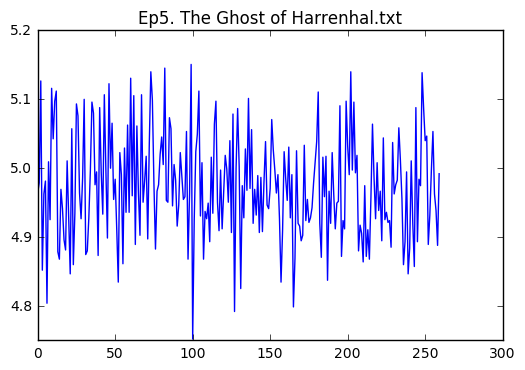

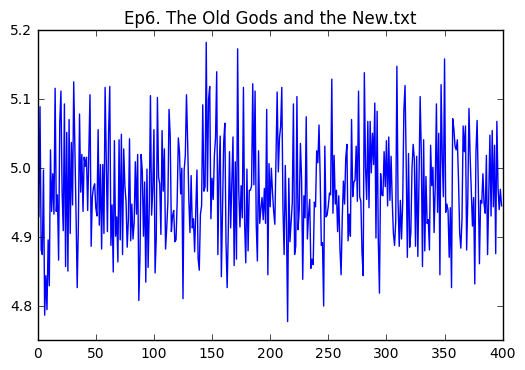

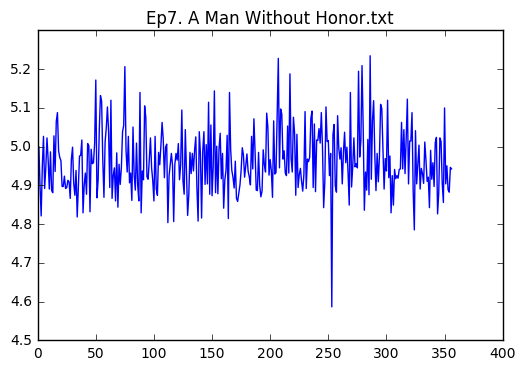

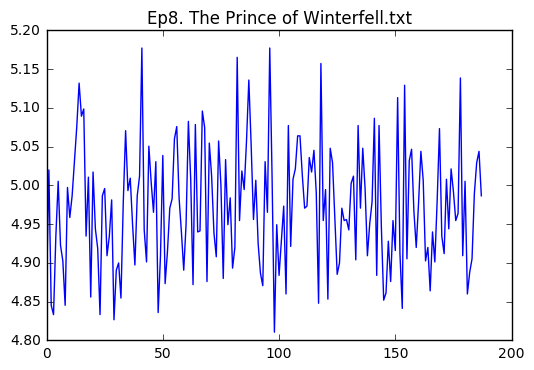

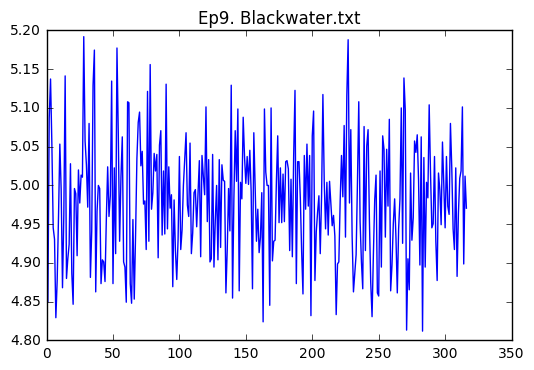

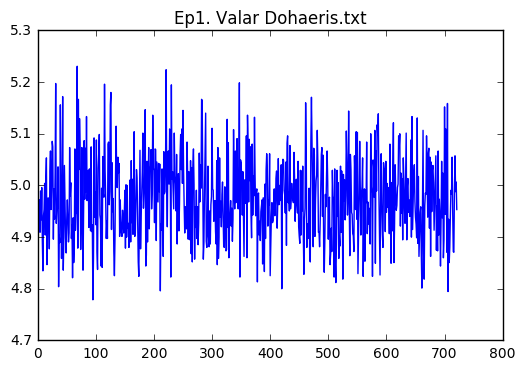

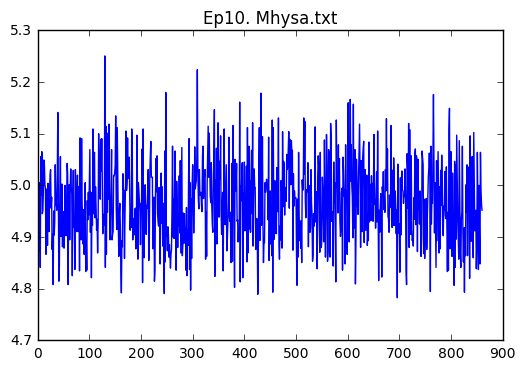

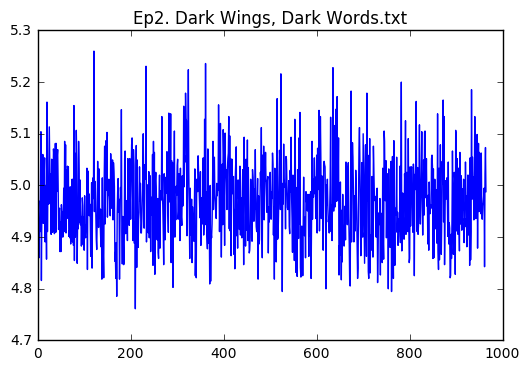

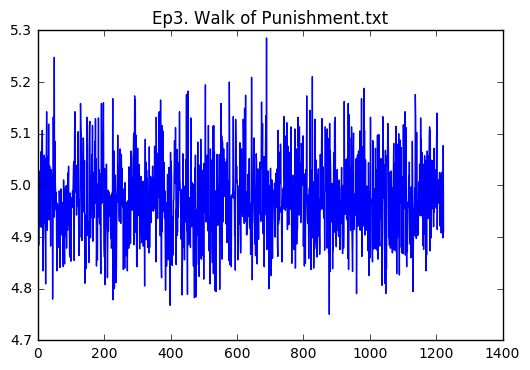

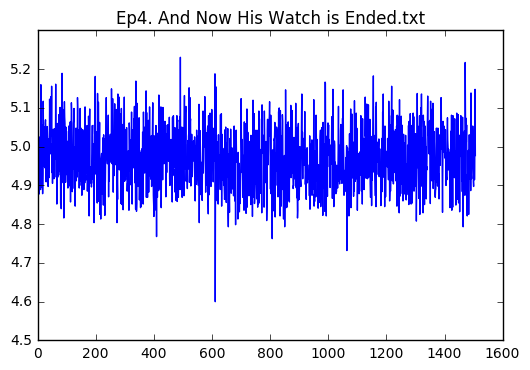

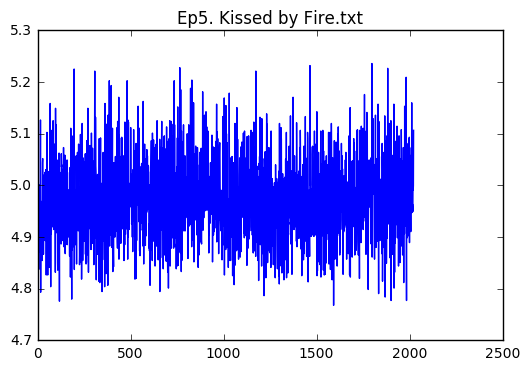

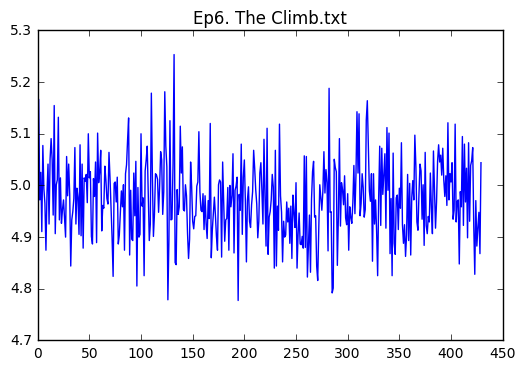

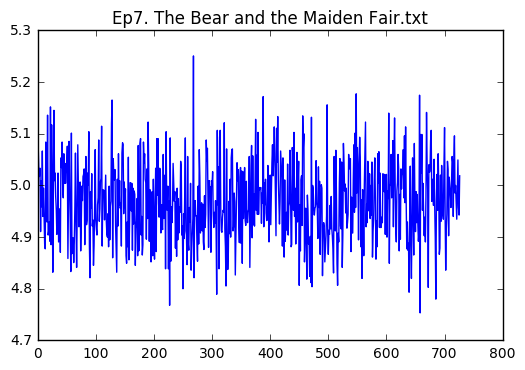

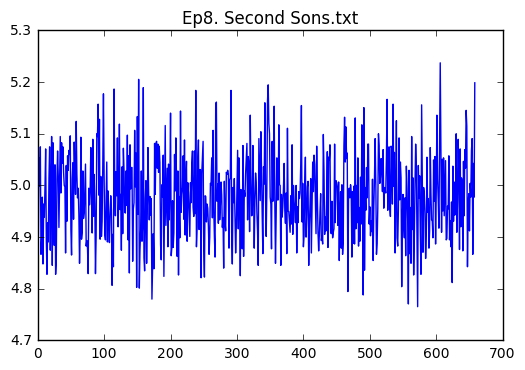

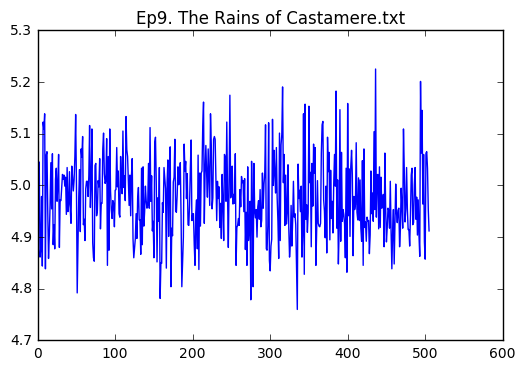

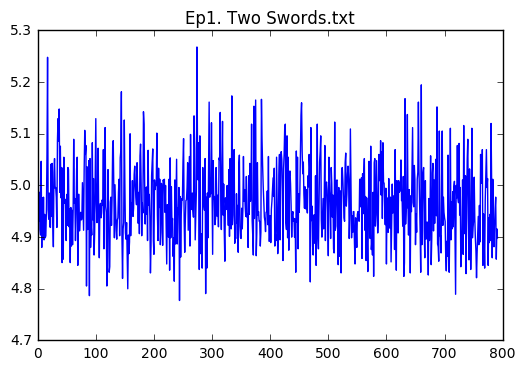

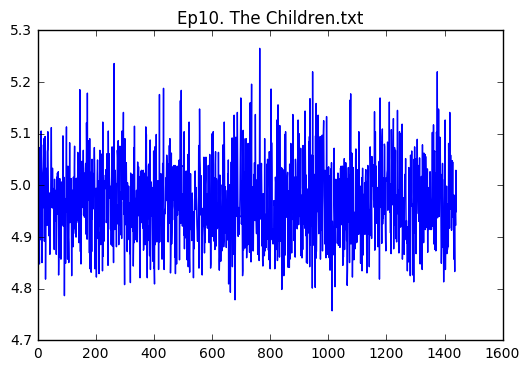

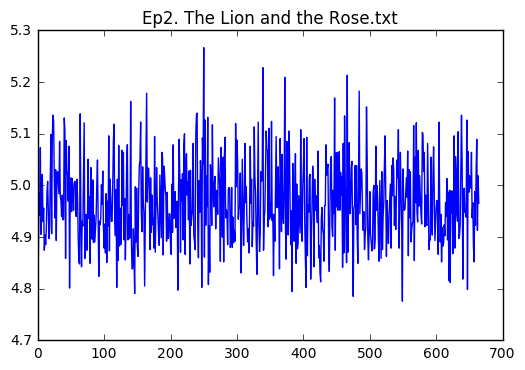

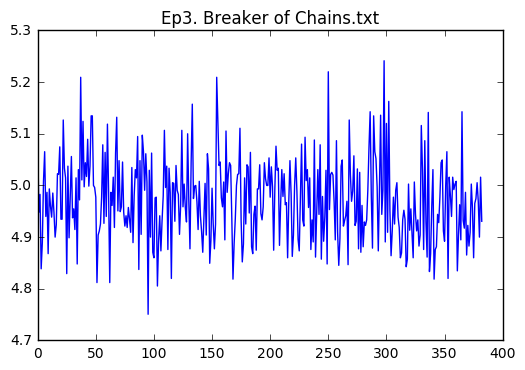

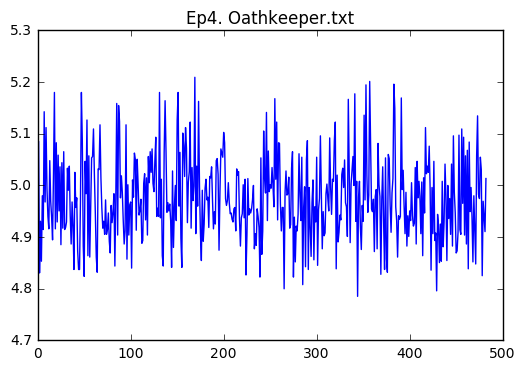

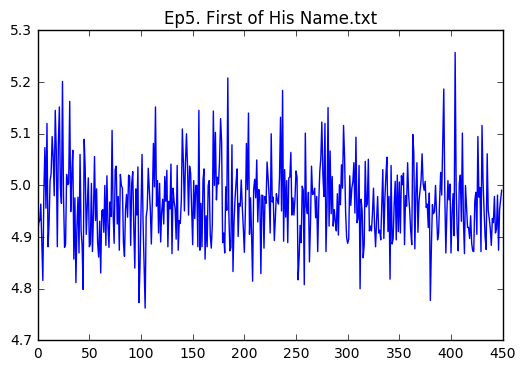

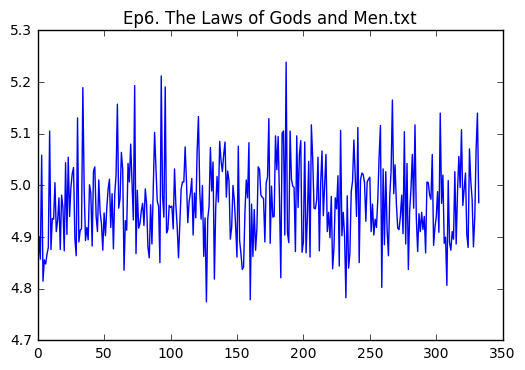

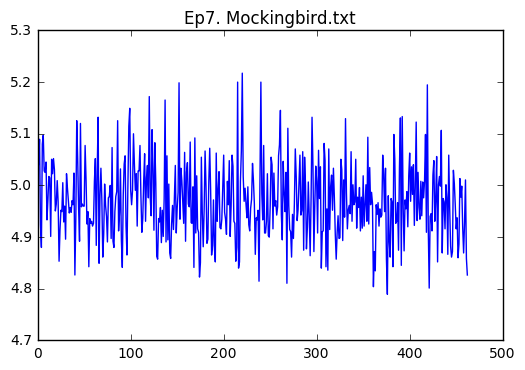

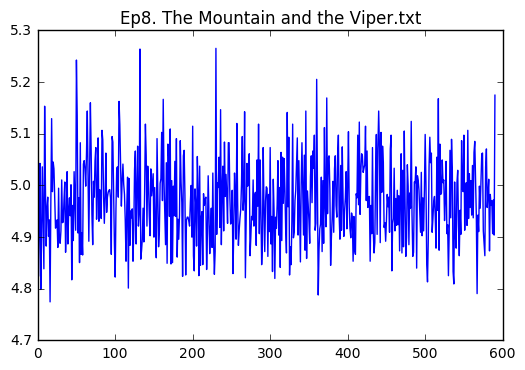

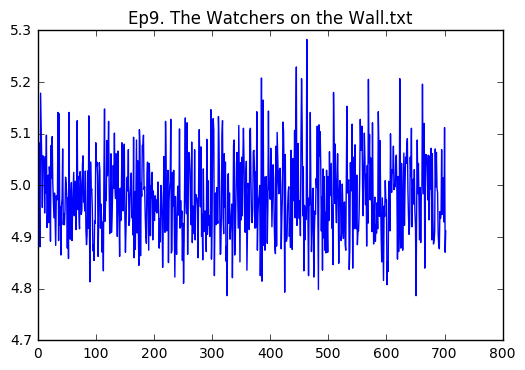

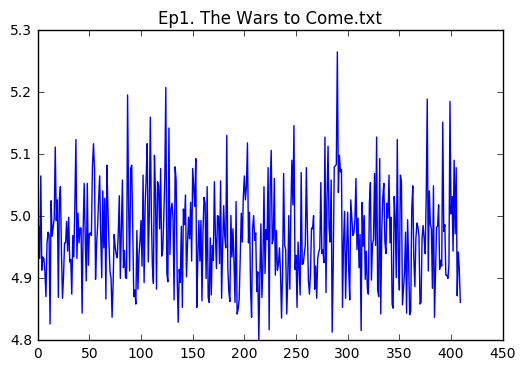

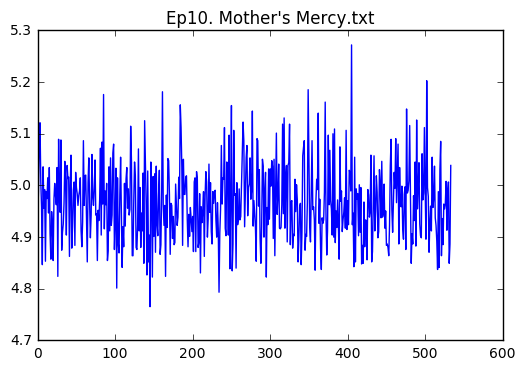

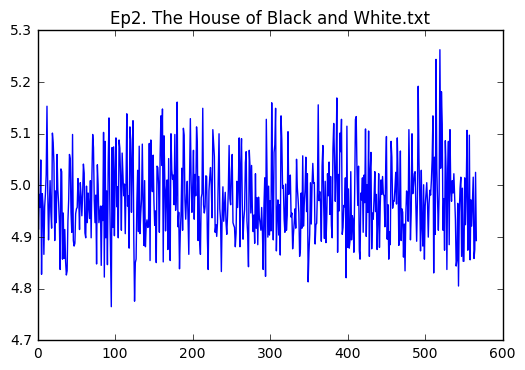

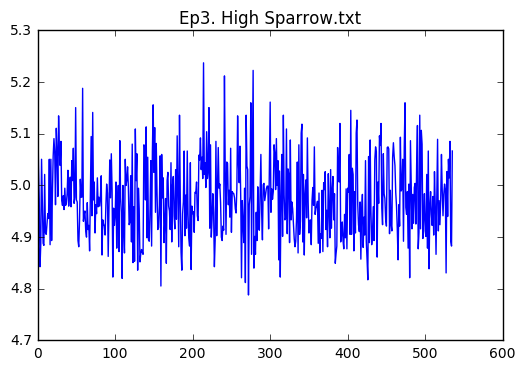

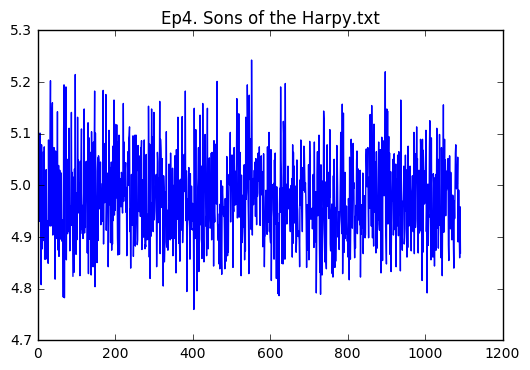

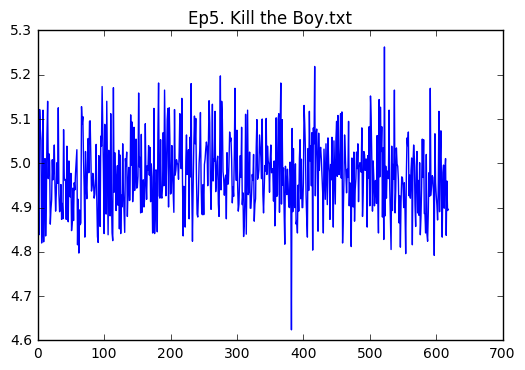

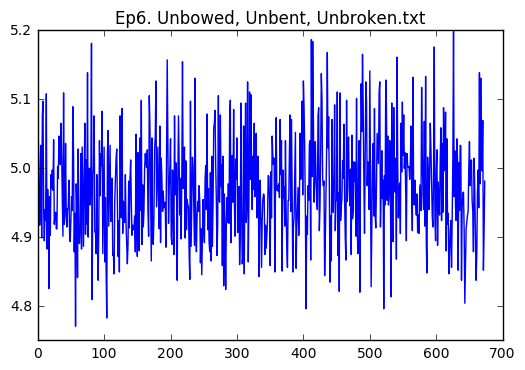

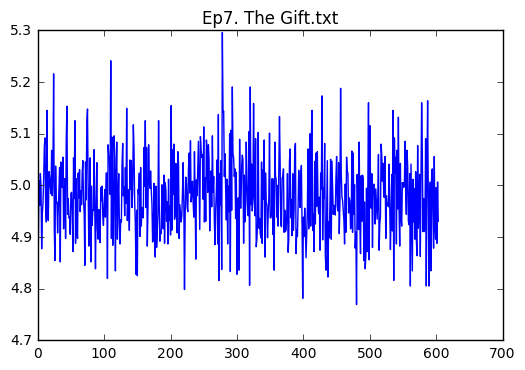

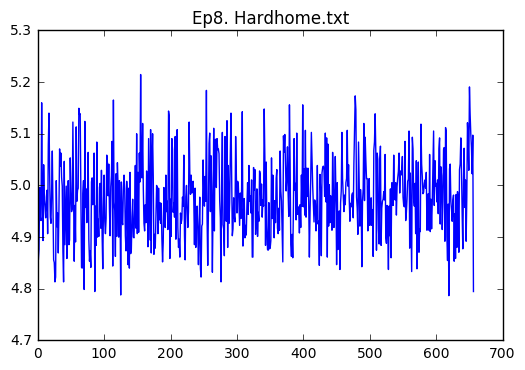

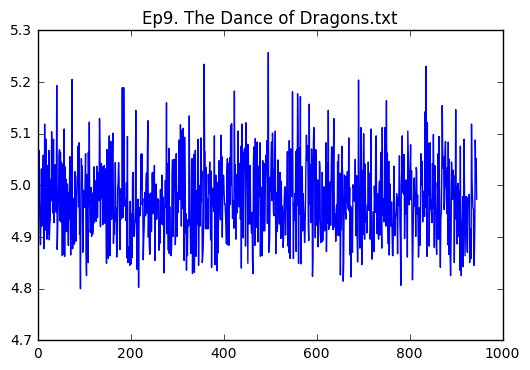

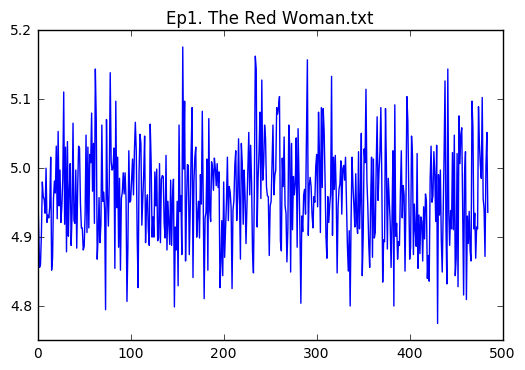

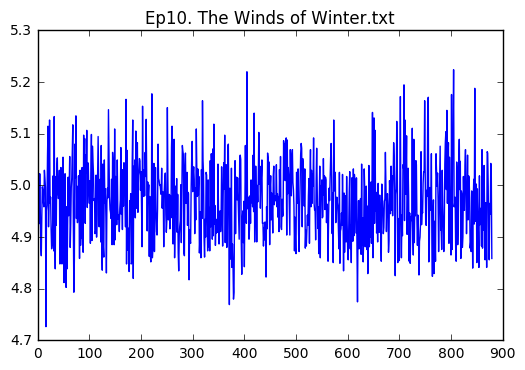

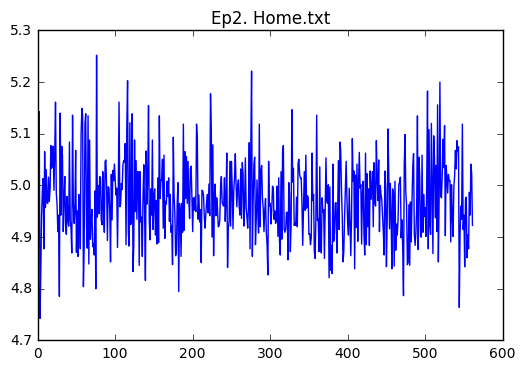

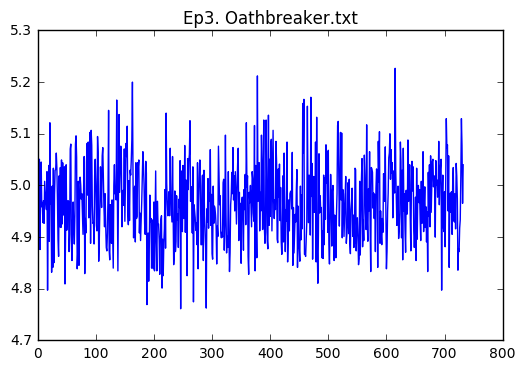

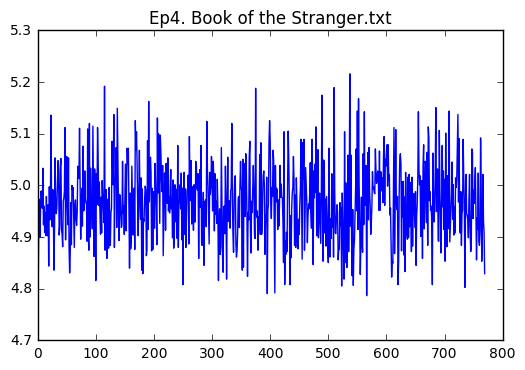

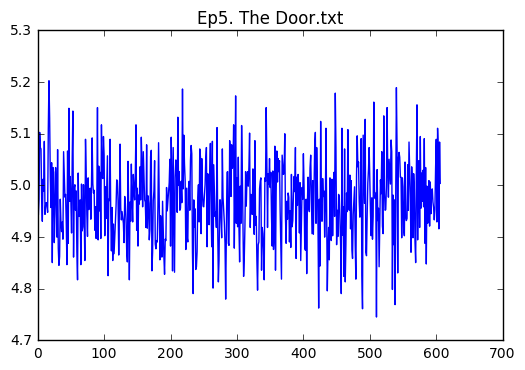

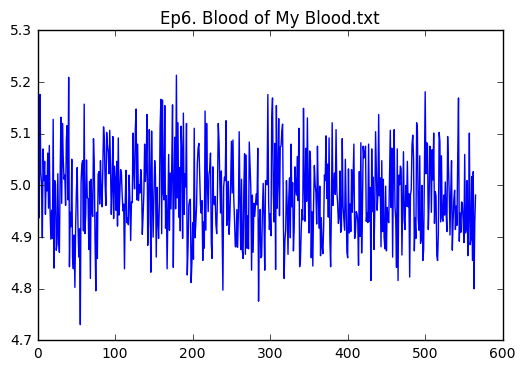

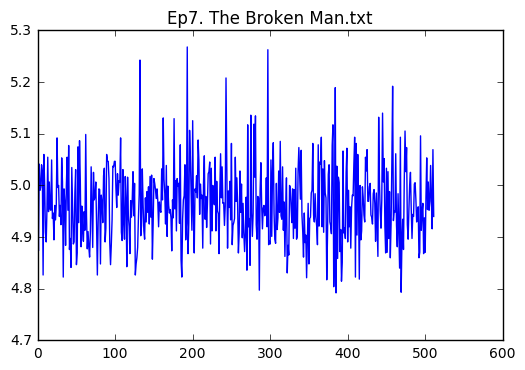

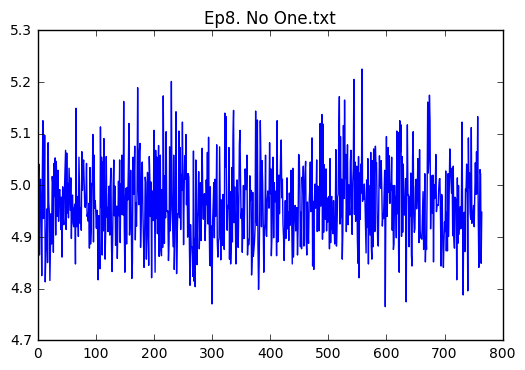

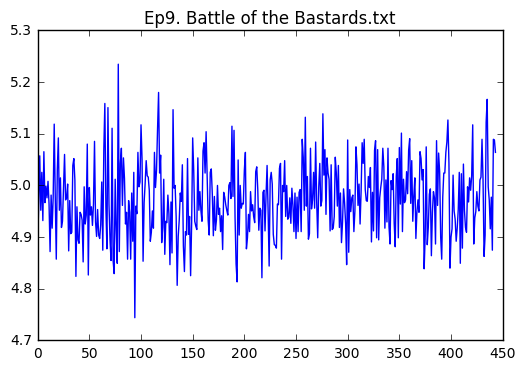

In [60]:
#We then plot all 60 moving average sentiment analysis plots
for i in range(10):
    plt.plot(a1[i],'-') #season 1
    plt.title(season1names[i])
    plt.show()
    
for i in range(10):
    plt.plot(a2[i],'-') #season 2
    plt.title(season2names[i])
    plt.show()
    
for i in range(10):
    plt.plot(a3[i],'-') #season 3
    plt.title(season3names[i])
    plt.show()
    
for i in range(10):
    plt.plot(a4[i],'-') #season 4
    plt.title(season4names[i])
    plt.show()
    
for i in range(10):
    plt.plot(a5[i],'-') #season 5
    plt.title(season5names[i])
    plt.show()
    
for i in range(10):
    plt.plot(a6[i],'-') #season 6
    plt.title(season6names[i])
    plt.show()

We can see that all the episodes swings around the value of 5. Which makes sense seeing as the episodes are mainly "unhappy/intense" but we do see times when the value spikes up a bit, this is for example when a wedding or something nice happens. Obviously, because this is Game of Thrones, things such as a wedding, although it word wise is happy doesn't mean that the scene it actually happens in is happy i.e the red wedding and the purple wedding.

Furthermore, a series like Game of Thrones with so many deaths and bad things happening, it makes sense that each episode swings in such a way mood wise.

The reason why we chose a window size of 15, is because it gives a nice overall view of each episode, while a window of for example 500 wouldn't show a lot seeing as some of the summaries are close to being of length 500.

Also it seems like almost every episode has at least one point where the sentiment drops below a value of 4.8 which isn't really a suprise either seeing as a lot of episodes has a "shock scene".

## Discussion

Generally we thought it went very well. We succeeded in creating a Game of Thrones network, and finding the most important characters according to in and out degree, eigenvector centrality and betweenness centrality. All of these tools combined succeeded in finding the important characters. We also found the communities of the network, using the Python-Louvain algorithm. Not only did the communities make sense if you know the Game of Thrones universe, but using the tools we also succeeded in finding the important characters inside these communities. For all of these communities we also succeeded in making word clouds, which shows us the most used words for these communities. 

Last but not least we succeeded in making sentiment analysis of all the episodes, where we saw that generally all the episodes are "unhappy/intense", but there are some places where it spikes up. Also the sentiment analysis isn't always correct, since it sees words such as "wedding" to be happy, but weddings known as the "red wedding" and the "purple wedding" are anything but happy, with death involved. 


If we had more time we would have liked to download these episode summaries using the Wikipedia API or something else, instead of doing it manually. Also the episode summaries are very short, so it would have been cool to find the manuscripts for the episodes or something similar, to give a better sentiment analysis.

## References

[1] Wikipedia. Eigenvector centrality. (2016). Retrieved November 30, 2016 from https://en.wikipedia.org/wiki/Eigenvector_centrality 

[2] Wikipedia. Betweenness centrality. (2016). Retrieved November 30, 2016 from https://en.wikipedia.org/wiki/Betweenness_centrality

[3] ALBERT-LÁSZLÓ BARABÁSI.NETWORK SCIENCE: The Meaning of Scale-Free. eng. page 39.

[4] ALBERT-LÁSZLÓ BARABÁSI.NETWORK SCIENCE: COMMUNITIES. eng. pages 19-23.

[5] Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter. LabMT wordlist. (2011). Retrieved December 5, 2016 from http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752